# MIT License

Copyright (c) 2022 Karan Raman Agrawal

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.



# Abstract:
This dataset about wine and its quality based on some features. It is used in wine industry to check the quality of wine.

# Aim: 
In this assignment we aim to interpret the results of 
- Linear Model
- Tree Based Model
- Best model of AutoML H2O
 
Using different Model Interpretibility Methods.
 
In this excercise I have used
- SHAP analysis
- LIME analysis
- Partial Dependence Plot Analysis

#Variable Description
1) **Fixed Acidity** - Quantity of non volatile acids in the wine.               
2) **Volatile Acidity** - Quantity of volatile acids like acetic acid in the wine.                                                                     
3) **Citric Acid** - Quantity of citric acid in wine, which gives sour taste to wine                                                             
4) **Residual Sugar** - Amount of sugar left in the wine after the process of fermentation                                                         
5) **Chlorides** - Quantity of salts in wine                               
6) **Free Sulphur dioxide** - Amount of free form of SO2, which prevents the oxidation of wine                                                 
7) **Total Sulphur dioxide** - Total Amount of SO2 - free and bonded in wine.    
8) **Density** - Density of wine       
9) **pH** - pH value of wine                          
10) **Sulphates** - Amount of sulphates in wine used as wine additive           
11) **Alcohol** - Quantity of alcohol on wine                                   
12) **Quality** - Output variable between (0 to 10)

In [1]:
# Importing all libraries necessary for the assignment
!pip install shap
!pip install lime
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install h2o

import pandas as pd
import numpy as np
import shap
import lime
from lime import lime_tabular
import sklearn
from sklearn.model_selection import train_test_split
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import plot_partial_dependence
from matplotlib.pyplot import figure
from sklearn.tree import export_graphviz
import pydot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (32, 24)

     |████████████████████████████████| 564 kB 5.3 MB/s 
     |████████████████████████████████| 275 kB 3.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=d32145f3801cc5c4b3274beb726850d4a642e09903be2ae7ae951071596a97f5
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
     |████████████████████████████████| 177.0 MB 20 kB/s 
  Created wheel for h2o: filename=h2o-3.36.1.1-py2.py3-none-any.whl size=177068062 sha256=cabc389731ddb336dbff62b982b9fef52eff461728c8188bd5084f61a20f6b3f
  Stored in directory: /root/.cache/pip/wheels/a6/d9/ab/5442447c7e2ccf07f66aa8b79f3877ce5382f0b95e6c0c797b
Successfully built h2o


In [2]:
# Setting up maximum runtime for the AutoML
min_mem_size = 6
run_time = 222

In [3]:
# Setting up memory
pct_memory = 0.5
virtual_memory = psutil.virtual_memory()
min_mem_size = int(round(int(pct_memory * virtual_memory.available) / 1073741824, 0))
print(min_mem_size)

6


In [4]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no = random.randint(5555, 55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
    h2o.init(
        strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no
    )  # start h2o
except:
    logging.critical("h2o.init")
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:31055 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.14.1" 2022-02-08; OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmppbs4irma
  JVM stdout: /tmp/tmppbs4irma/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmppbs4irma/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:31055
Connecting to H2O server at http://127.0.0.1:31055 ... successful.


--------------------------  ----------------------------------
H2O_cluster_uptime:         04 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.1.1
H2O_cluster_version_age:    1 day
H2O_cluster_name:           H2O_from_python_unknownUser_flwdsy
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    6 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:31055
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.7.13 final
--------------------------  ----------------------------------

In [5]:
wine_df = pd.read_csv(
    "/content/drive/MyDrive/WineQT.csv"
)  # Reading CSV file into Pandas DataFrame

In [6]:
X = wine_df.drop(["quality", "Id"], axis=1)  # Training Feature
Y = wine_df["quality"]  # Target

In [7]:
(
    x_train,
    x_test,
    y_train,
    y_test,
) = train_test_split(  # Splitting Data into Training and Test
    X, Y, test_size=0.1, random_state=42
)
x_train_100 = shap.utils.sample(
    x_train, 100
)  # Taking 100 samples out for SHAP analysis as it is a computationally expensive process
x_test_100 = shap.utils.sample(
    x_test, 100
)  # Taking 100 samples out for SHAP analysis as it is a computationally expensive process

#Fitting a Linear Model

In [8]:
linear_model = sklearn.linear_model.LinearRegression()  # Initializing a Linear Model
linear_model.fit(x_train, y_train)  # Training a linear model

LinearRegression()

In [9]:
# Scaling the data using Min-Max scaling for the purpose of evaluating Co-efficients, as non scaled data may mislead while we evaluate the co-efficients
df = wine_df.drop("quality", axis=1)
df_norm = (df - df.min()) / (df.max() - df.min())
df_norm = pd.concat((df_norm, wine_df.quality), 1)

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [10]:
import statsmodels.formula.api as smf  # OLS model Library

results = smf.ols(
    "quality ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide +density + pH + sulphates + alcohol + Id",
    data=df_norm,
).fit()
print(results.summary())  # OLS Linear Model Summary

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     56.45
Date:                Fri, 15 Apr 2022   Prob (F-statistic):          2.11e-106
Time:                        04:00:19   Log-Likelihood:                -1106.2
No. Observations:                1143   AIC:                             2238.
Df Residuals:                    1130   BIC:                             2304.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.8140 

#Interpreting Regression Co-efficients
**Model Co-efficients**

The positive or negative value of a co-eficient tells us if there is a positve or a negtive correlationship between the target and predictors. A positive value indicates that the value of target *increases* if the value of co-efficient *increases* and vice-versa. Whereas the negative values indicates that the value of target *increases* if the value of co-efficient *decreases* and vice versa.

As seen in the co-efficient coloumn in the above table
- Value for the variable alcohol is highest = 1.8395
- Followed by sulphates = 1.4434 

High absolute values of co-efficients can be used to get an idea of the importance of variables in a linear regression. Here, as stated above Alcohol and Sulphates seems to be the most important variables to predict target i.e. Quality of Wine. 

Also, it signifies that Higher the qualtity of Alcohol and sulphates - better is the quality of Wine.

**P-Values**

If the p-value is 0.05 or lower, the result is trumpeted as significant, but if it is higher than 0.05, the result is non-significant
- volatile_acidity
- chlorides
- total_sulfur_dioxide
- alcohol
- sulphate

These variables have P-Value less that 0.05, hence it can be interpreted that these variables are significant variables and any change to this variables have significant impact on the target (Wine Quality).

**Skew and Kurtosis**

Skewness tells us the amount and direction of skew(Departure from the central axis) and Kurtosis tells us how tall and sharp the central peak is. The optimum value for these two measures is 0, in our case we have a value for Skew and Kurtosis as -0.143, 3.717 respectively.

**Durbin-Watson**

The Durbin-Watson test is a statistical test to detect auto-correlation in the residuals of a regression analysis. Its range is 0 to 4.
- Value of 2 indicates that no auto correlation is detected
- Value between 0 to 2 indicates that there is positive auto correlation detected
- Value between 2 to 4 indicates that there is negatibe auto correlation detected

Our model has a DW score of 1.780 which could be interpreted as a positive auto-correlation in the residuals of regression. 

**Jarque-Bera Test**

The JB test is known as the test of Normality, irrespective if the data has skew or kurtosis. If it is far from zero, it signals the data do not have a normal distribution. Our JB value is 28.421 which again re-inforces the interpretation we got from Skew and Kurtosis. 

#Fit Tree Based Model

In [11]:
# Setting the max_dept to 3 for the purpose of ease of explainbility and readability
tree_model = RandomForestRegressor(max_depth=3, random_state=0, n_estimators=10)
tree_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=10, random_state=0)

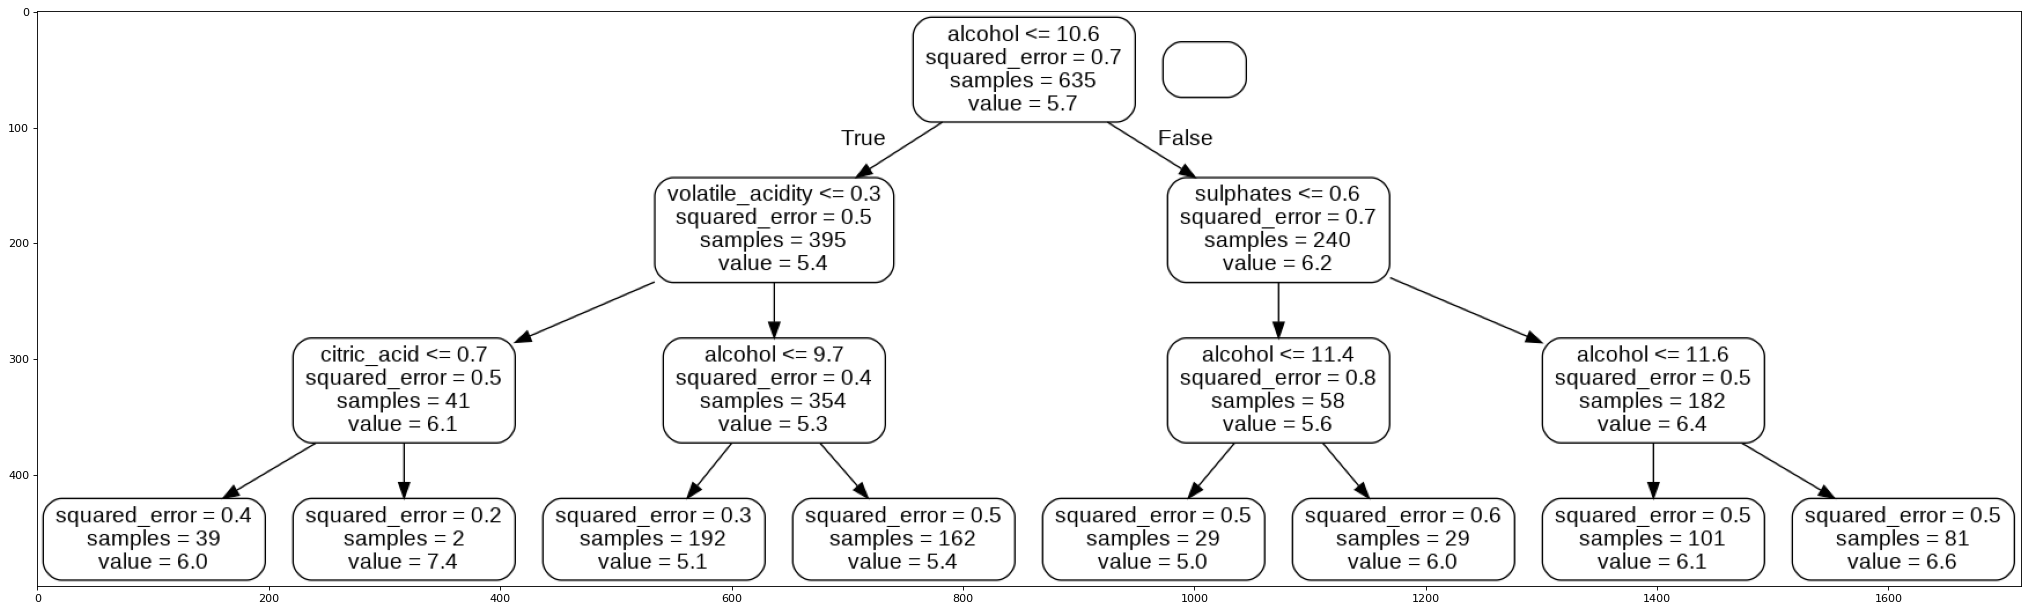

In [12]:
# Visualization of Nodes for the purpose of explainability
figure(figsize=(32, 24), dpi=80)
tree = tree_model.estimators_[0]
export_graphviz(
    tree,
    out_file="tree.dot",
    feature_names=list(x_train.columns),
    rounded=True,
    precision=1,
)
(graph,) = pydot.graph_from_dot_file("tree.dot")
graph.write_png("tree.png")
img = mpimg.imread("tree.png")
imgplot = plt.imshow(img)
plt.show()

# Interpreting Nodes of a Tree-Based Model

Random Forest Regressor works on the concept of the wisdom of the crowd. The above decision tree is one of the many trees involved in predicting the target variable. Each decision tree regression predicts a number as an output for a given input. Random forest regression takes the average of those predictions as its *final* output.

As usual, the tree has conditions on each internal node and a value associated with each leaf (i.e. the value to be predicted). But additionally, we’ve plotted out the value at each internal node i.e. the mean of the response variables in that region.

Let us try to understand how the above decision tree is working by interpreting the nodes starting from the extreme left side as leaf 1.

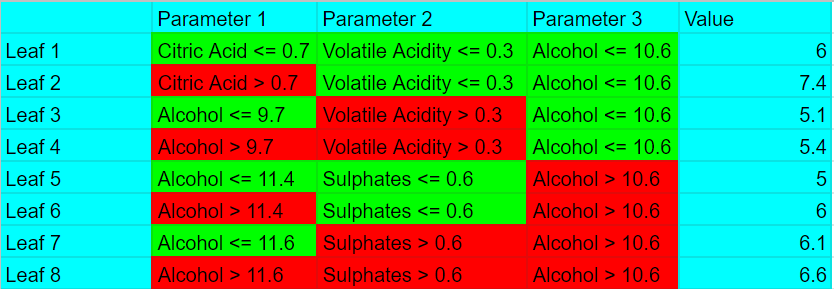

Please refer to the above figure to understand the nodes
The first leaf gets gains from all parameters as the condition satisfied for all 3 parameters
The second leaf gets gains from parameters 2, and 3 but not from parameters 1
And Similarly, the red marked cells are the losses incurred and Green marked cells are the gains incurred from the parameters which give us output as values for this specific decision tree




In [13]:
# Get numerical feature importances
tree_importances = list(tree_model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [
    (feature, round(importance, 2))
    for feature, importance in zip(x_train.columns, tree_importances)
]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

In [14]:
# Print out the feature and importances
[print("Variable: {:20} Importance: {}".format(*pair)) for pair in feature_importances];

Variable: alcohol              Importance: 0.57
Variable: volatile_acidity     Importance: 0.2
Variable: sulphates            Importance: 0.18
Variable: fixed_acidity        Importance: 0.02
Variable: chlorides            Importance: 0.01
Variable: free_sulfur_dioxide  Importance: 0.01
Variable: total_sulfur_dioxide Importance: 0.01
Variable: pH                   Importance: 0.01
Variable: citric_acid          Importance: 0.0
Variable: residual_sugar       Importance: 0.0
Variable: density              Importance: 0.0


The variable importance we get from the tree-based regressor re-inforces our interpretation from the linear model.

#Getting best model using H2O AutoML

In [15]:
wine_hf = h2o.H2OFrame(wine_df)  # Converting Pandas dataframe in H2O dataframe

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [16]:
pct_rows = 0.80  # Setting up the data split between training and test dataset.
df_train, df_test = wine_hf.split_frame([pct_rows])

In [17]:
# Setting up AutoML
def autoML(df_train, df_test):
    X = df_train.columns
    y = "quality"

    X.remove(y)  # Removing the result frm our predictors data
    X.remove("Id")  # Removing ID from the predictor's data, as it is not related

    aml = H2OAutoML(max_runtime_secs=222, seed=1)  # Setting of AutoML
    aml.train(
        x=X, y=y, training_frame=df_train
    )  # Trainig the dataset on different models

    return df_train, df_test, aml


# Function to get best model from the AutoML leaderboard
def getBestModel(aml):
    model_index = 0
    glm_index = 0
    glm_model = ""
    aml_leaderboard_df = aml.leaderboard.as_data_frame()
    models_dict = {}

    for m in aml_leaderboard_df["model_id"]:
        models_dict[m] = model_index
        if "StackedEnsemble" not in m:
            break
        model_index = model_index + 1

    for m in aml_leaderboard_df["model_id"]:
        if "GLM" in m:
            models_dict[m] = glm_index
            break
        glm_index = glm_index + 1

    print(model_index)
    best_model = h2o.get_model(aml.leaderboard[model_index, "model_id"])
    return best_model

In [18]:
autoML = autoML(df_train, df_test)  # Training AutoML

AutoML progress: |██████████████████████████████████████████████████████████████
04:04:04.66: GBM_lr_annealing_selection_AutoML_1_20220415_40023 [GBM lr_annealing] failed: water.exceptions.H2OIllegalArgumentException: Can only convert jobs producing a single Model or ModelContainer.

█| (done) 100%


In [19]:
autoML[2].leaderboard  # Leaderbord of AutoML output

model_id rmse mse mae rmsle mean_residual_deviance 
 
 
 StackedEnsemble_BestOfFamily_4_AutoML_1_20220415_40023 0.588089 0.345849 0.423937 0.0910113 0.345849 
 StackedEnsemble_AllModels_4_AutoML_1_20220415_40023 0.588172 0.345946 0.437371 0.0910034 0.345946 
 StackedEnsemble_AllModels_3_AutoML_1_20220415_40023 0.589538 0.347555 0.438063 0.0911752 0.347555 
 StackedEnsemble_BestOfFamily_3_AutoML_1_20220415_40023 0.592972 0.351616 0.432585 0.0916845 0.351616 
 StackedEnsemble_AllModels_2_AutoML_1_20220415_40023 0.593901 0.352719 0.432971 0.0918756 0.352719 
 XRT_1_AutoML_1_20220415_40023 0.597285 0.356749 0.439888 0.0925344 0.356749 
 StackedEnsemble_AllModels_1_AutoML_1_20220415_40023 0.59826 0.357915 0.440764 0.0926023 0.357915 
 GBM_grid_1_AutoML_1_20220415_40023_model_15 0.59928 0.359137 0.441272 0.092912 0.359137 
 GBM_5_AutoML_1_20220415_40023 0.59999 0.359988 0.444927 0.0928745 0.359988 
 GBM_grid_1_AutoML_1_20220415_40023_model_5 0.600524 0.360629 0.453927 0.0927413 0.360629

In [20]:
autoML_model = getBestModel(autoML[2])  # Getting Best Model
print(autoML_model)

5
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  XRT_1_AutoML_1_20220415_40023


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               36.0                      36.0             106762.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       14.0       20.0   18.166666       208.0       256.0    231.05556



ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.3723222271305958
RMSE: 0.6101821261972492
MAE: 0.4504655003739082
RMSLE: 0.09423554582852128
Mean Residual Deviance: 0.3723222271305958

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.3567491402250199
RMSE: 0.5972848066249634
MAE: 0.43988786020910764
RMSLE: 0.09253439725193999
Mean Residual Deviance: 0.3567491402250199

Cross-Validation Metrics Summary: 


mean        sd  cv_1_valid  cv_2_valid  \
0                     mae  0.440015  0.037423    0.421969    0.424073   
1  mean_residual_deviance  0.355582  0.058250    0.346975    0.321094   
2                     mse  0.355582  0.058250    0.346975    0.321094   
3                      r2  0.448010  0.053785    0.463911    0.405552   
4       residual_deviance  0.355582  0.058250    0.346975    0.321094   
5                    rmse  0.594769  0.047858    0.589045    0.566651   
6                   rmsle  0.091944  0.010171    0.091802    0.083976   

   cv_3_valid  cv_4_valid  cv_5_valid  
0    0.496983    0.456028    0.401022  
1    0.447472    0.367752    0.294619  
2    0.447472    0.367752    0.294619  
3    0.402963    0.434201    0.533426  
4    0.447472    0.367752    0.294619  
5    0.668934    0.606426    0.542788  
6    0.106879    0.095739    0.081324


Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0    2022-04-15 04:01:03   5.695 sec              0.0            NaN   
1    2022-04-15 04:01:04   5.822 sec              5.0       0.755460   
2    2022-04-15 04:01:04   5.966 sec             10.0       0.691385   
3    2022-04-15 04:01:04   6.127 sec             15.0       0.651542   
4    2022-04-15 04:01:04   6.280 sec             20.0       0.634442   
5    2022-04-15 04:01:04   6.397 sec             25.0       0.621060   
6    2022-04-15 04:01:04   6.572 sec             30.0       0.612571   
7    2022-04-15 04:01:04   6.709 sec             35.0       0.611188   
8    2022-04-15 04:01:04   6.754 sec             36.0       0.610182   

   training_mae  training_deviance  
0           NaN                NaN  
1      0.499358           0.570720  
2      0.494474           0.478013  
3      0.480990           0.424506  
4      0.468326           0.402517  
5      0.460833           0.385716  
6      0.453871           0.375244  
7      0.451909           0.373551  
8      0.450466           0.372322


Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0                alcohol          3141.820557           1.000000    0.221120
1              sulphates          2095.800293           0.667066    0.147502
2       volatile_acidity          1858.066895           0.591398    0.130770
3            citric_acid          1169.271484           0.372164    0.082293
4                density          1102.745728           0.350989    0.077611
5   total_sulfur_dioxide           992.838562           0.316007    0.069876
6          fixed_acidity           909.584839           0.289509    0.064016
7                     pH           839.673706           0.267257    0.059096
8              chlorides           750.647522           0.238921    0.052830
9    free_sulfur_dioxide           685.177856           0.218083    0.048223
10        residual_sugar           663.008240           0.211027    0.046662

In [21]:
autoML_model.predict

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  XRT_1_AutoML_1_20220415_40023


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               36.0                      36.0             106762.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       14.0       20.0   18.166666       208.0       256.0    231.05556



ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.3723222271305958
RMSE: 0.6101821261972492
MAE: 0.4504655003739082
RMSLE: 0.09423554582852128
Mean Residual Deviance: 0.3723222271305958

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.3567491402250199
RMSE: 0.5972848066249634
MAE: 0.43988786020910764
RMSLE: 0.09253439725193999
Mean Residual Deviance: 0.3567491402250199

Cross-Validation Metrics Summary: 


mean        sd  cv_1_valid  cv_2_valid  \
0                     mae  0.440015  0.037423    0.421969    0.424073   
1  mean_residual_deviance  0.355582  0.058250    0.346975    0.321094   
2                     mse  0.355582  0.058250    0.346975    0.321094   
3                      r2  0.448010  0.053785    0.463911    0.405552   
4       residual_deviance  0.355582  0.058250    0.346975    0.321094   
5                    rmse  0.594769  0.047858    0.589045    0.566651   
6                   rmsle  0.091944  0.010171    0.091802    0.083976   

   cv_3_valid  cv_4_valid  cv_5_valid  
0    0.496983    0.456028    0.401022  
1    0.447472    0.367752    0.294619  
2    0.447472    0.367752    0.294619  
3    0.402963    0.434201    0.533426  
4    0.447472    0.367752    0.294619  
5    0.668934    0.606426    0.542788  
6    0.106879    0.095739    0.081324


Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0    2022-04-15 04:01:03   5.695 sec              0.0            NaN   
1    2022-04-15 04:01:04   5.822 sec              5.0       0.755460   
2    2022-04-15 04:01:04   5.966 sec             10.0       0.691385   
3    2022-04-15 04:01:04   6.127 sec             15.0       0.651542   
4    2022-04-15 04:01:04   6.280 sec             20.0       0.634442   
5    2022-04-15 04:01:04   6.397 sec             25.0       0.621060   
6    2022-04-15 04:01:04   6.572 sec             30.0       0.612571   
7    2022-04-15 04:01:04   6.709 sec             35.0       0.611188   
8    2022-04-15 04:01:04   6.754 sec             36.0       0.610182   

   training_mae  training_deviance  
0           NaN                NaN  
1      0.499358           0.570720  
2      0.494474           0.478013  
3      0.480990           0.424506  
4      0.468326           0.402517  
5      0.460833           0.385716  
6      0.453871           0.375244  
7      0.451909           0.373551  
8      0.450466           0.372322


Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0                alcohol          3141.820557           1.000000    0.221120
1              sulphates          2095.800293           0.667066    0.147502
2       volatile_acidity          1858.066895           0.591398    0.130770
3            citric_acid          1169.271484           0.372164    0.082293
4                density          1102.745728           0.350989    0.077611
5   total_sulfur_dioxide           992.838562           0.316007    0.069876
6          fixed_acidity           909.584839           0.289509    0.064016
7                     pH           839.673706           0.267257    0.059096
8              chlorides           750.647522           0.238921    0.052830
9    free_sulfur_dioxide           685.177856           0.218083    0.048223
10        residual_sugar           663.008240           0.211027    0.046662

<bound method ModelBase.predict of >

#SHAP, Partial Dependence Plot, Individual Conditional Expectation Analysis for AutoML Best Model

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

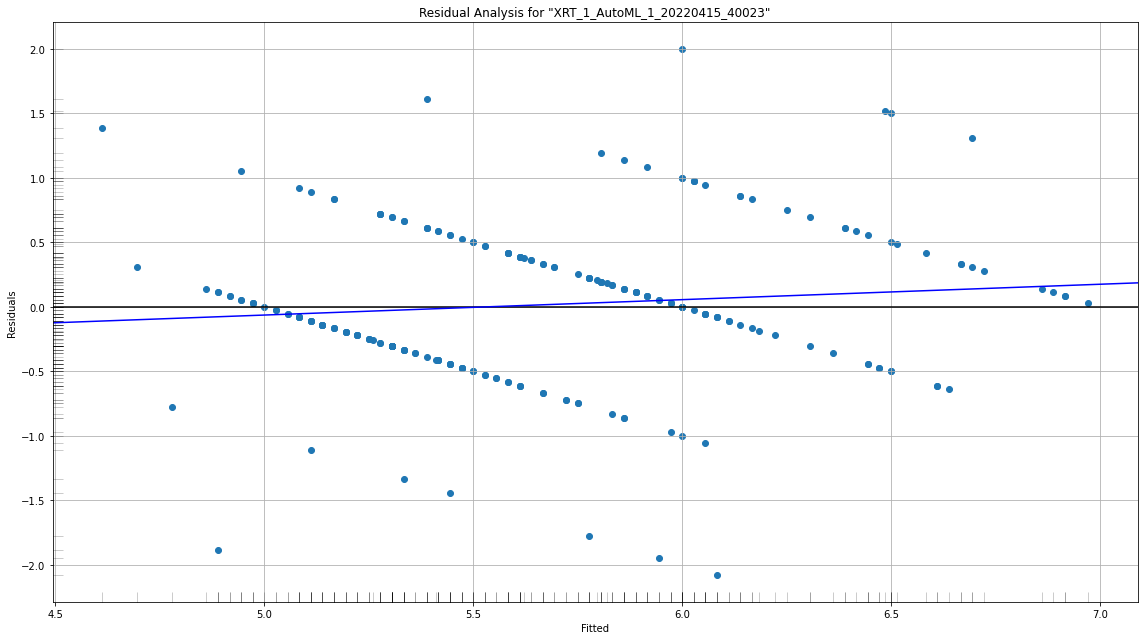

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

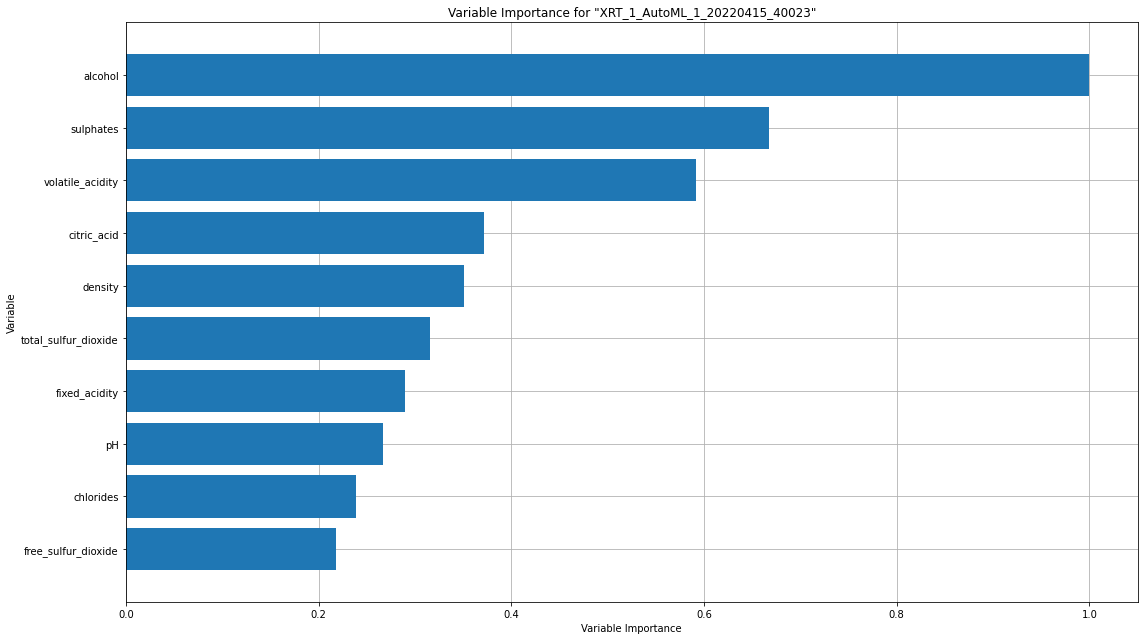

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

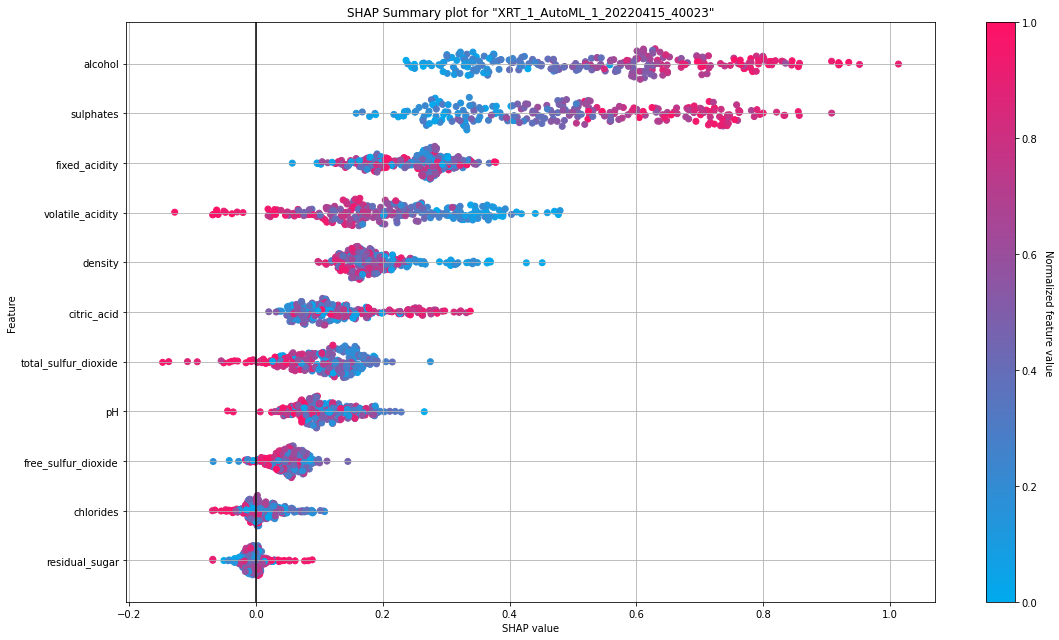

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

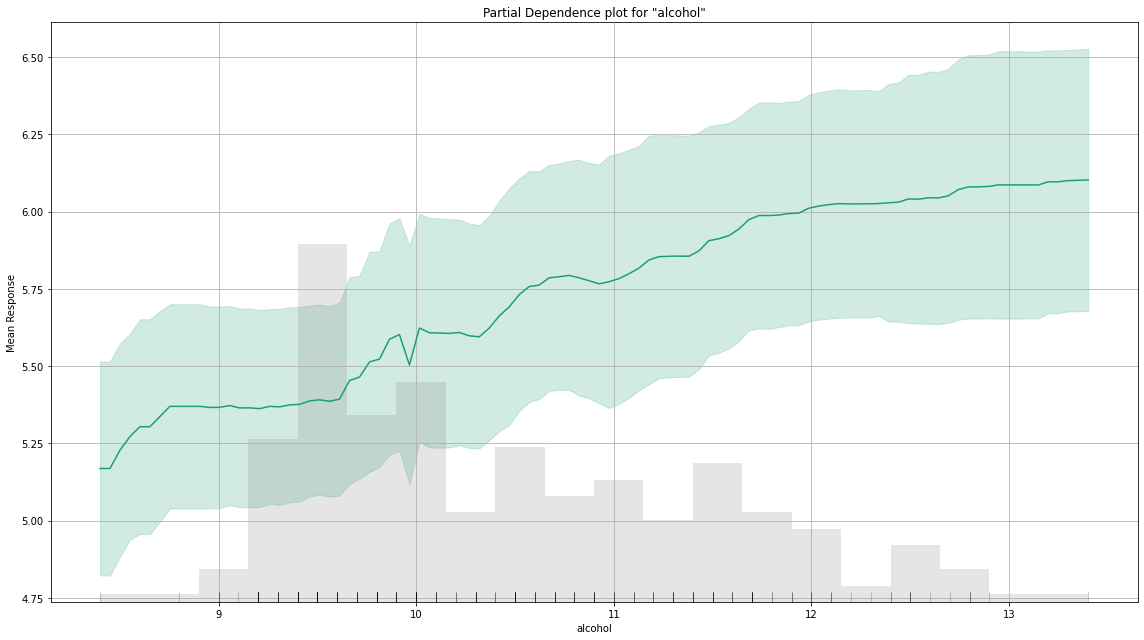

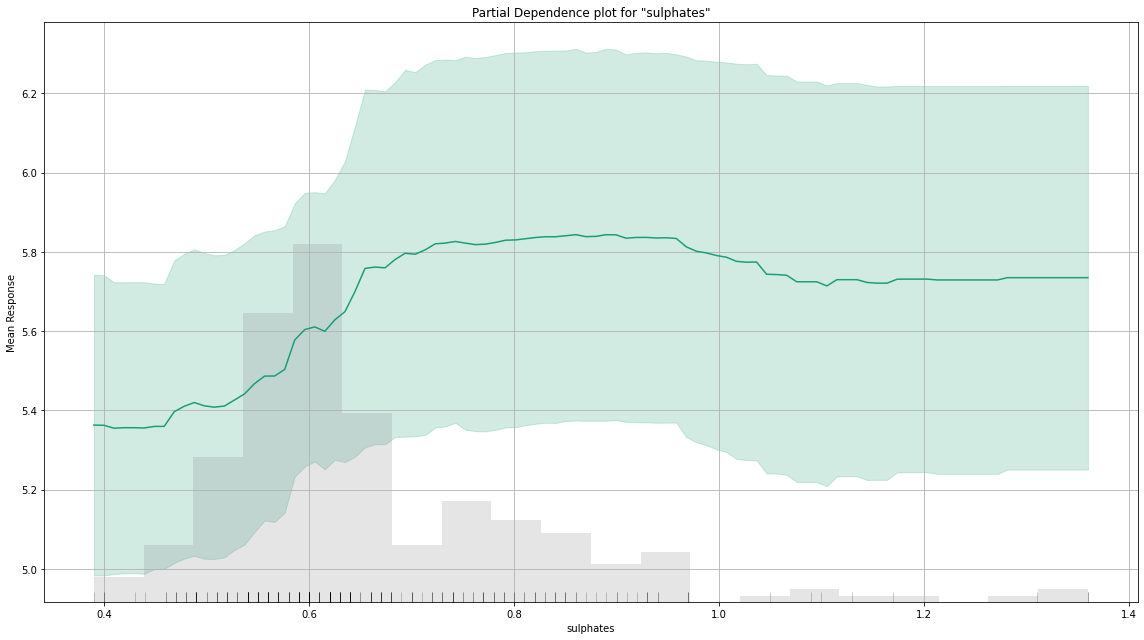

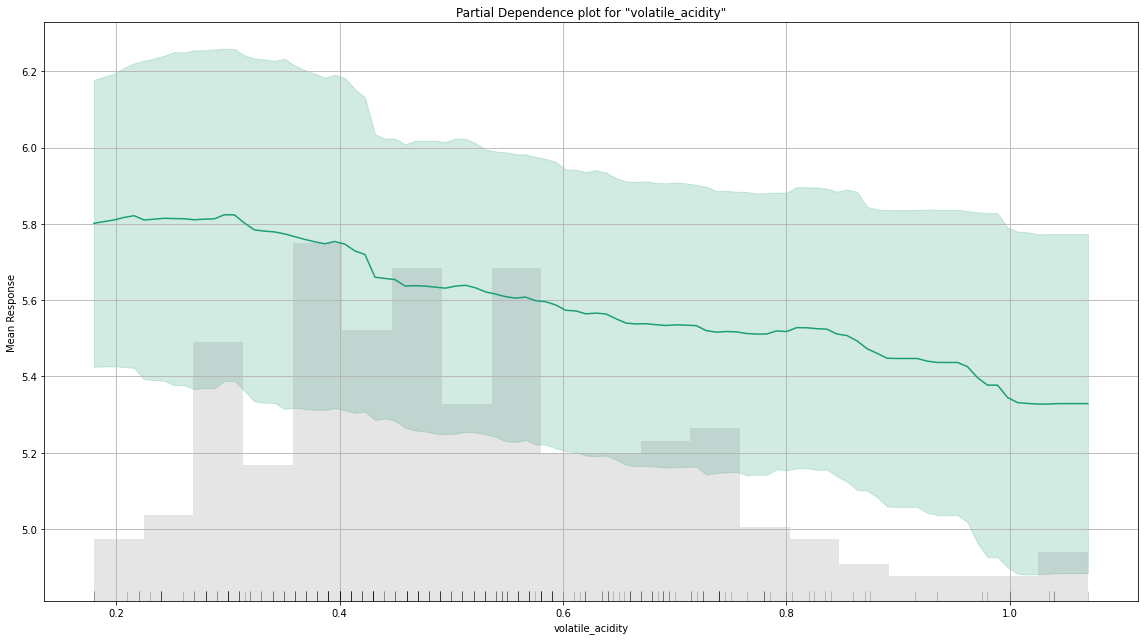

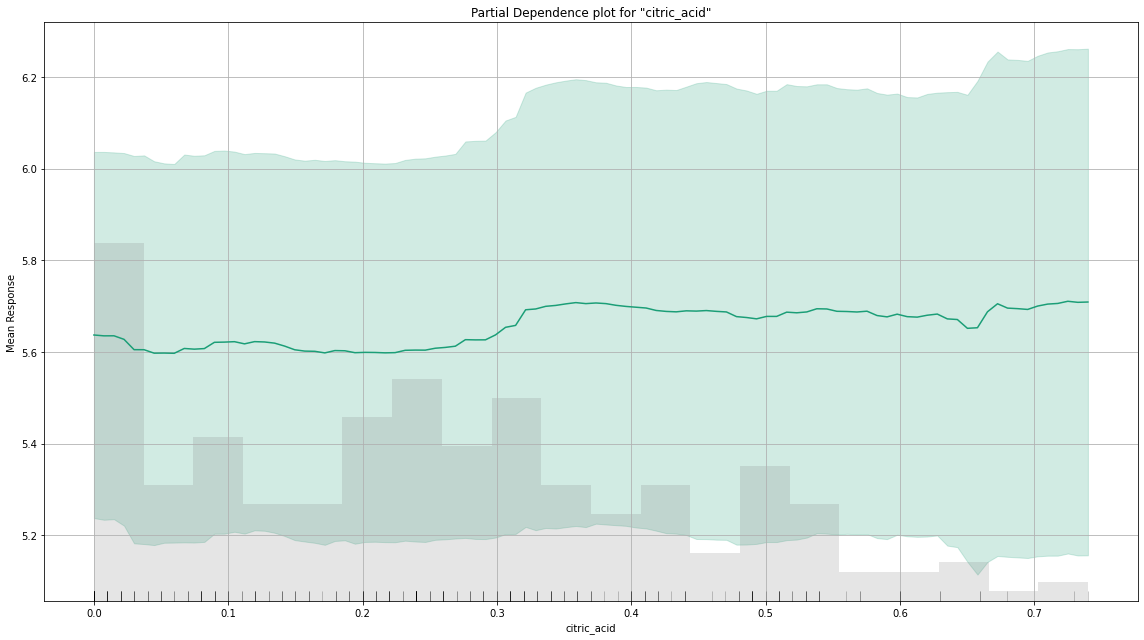

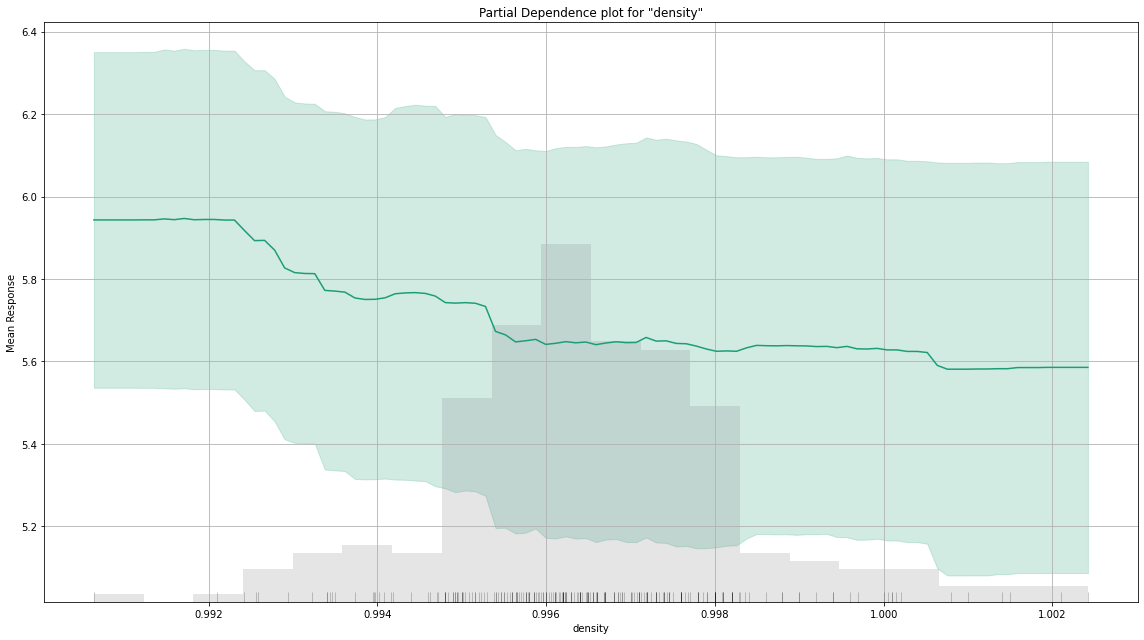

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

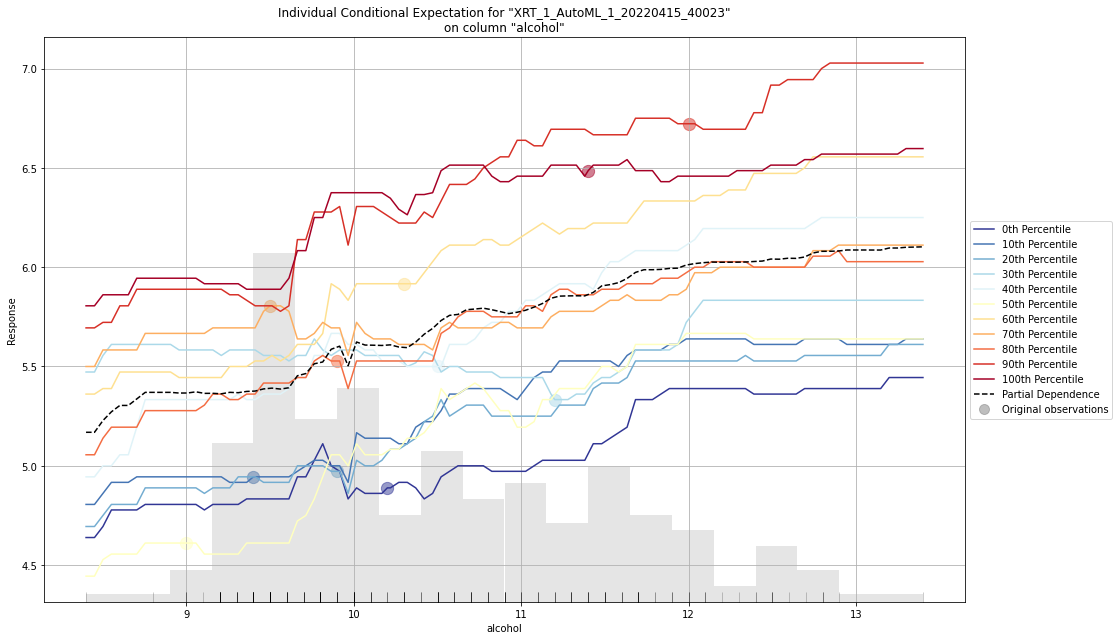

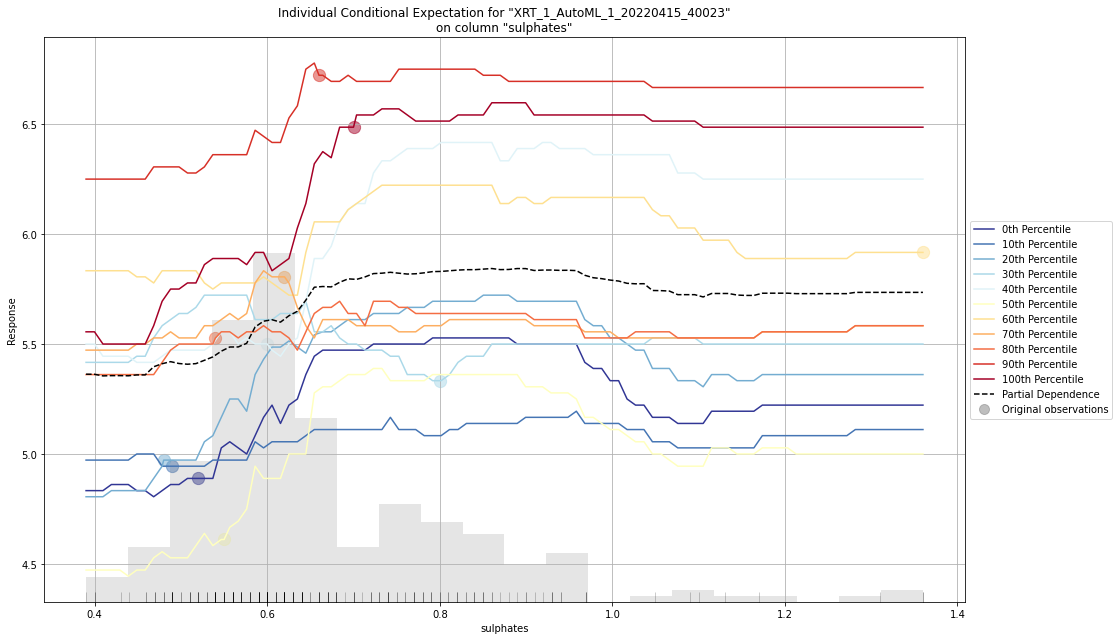

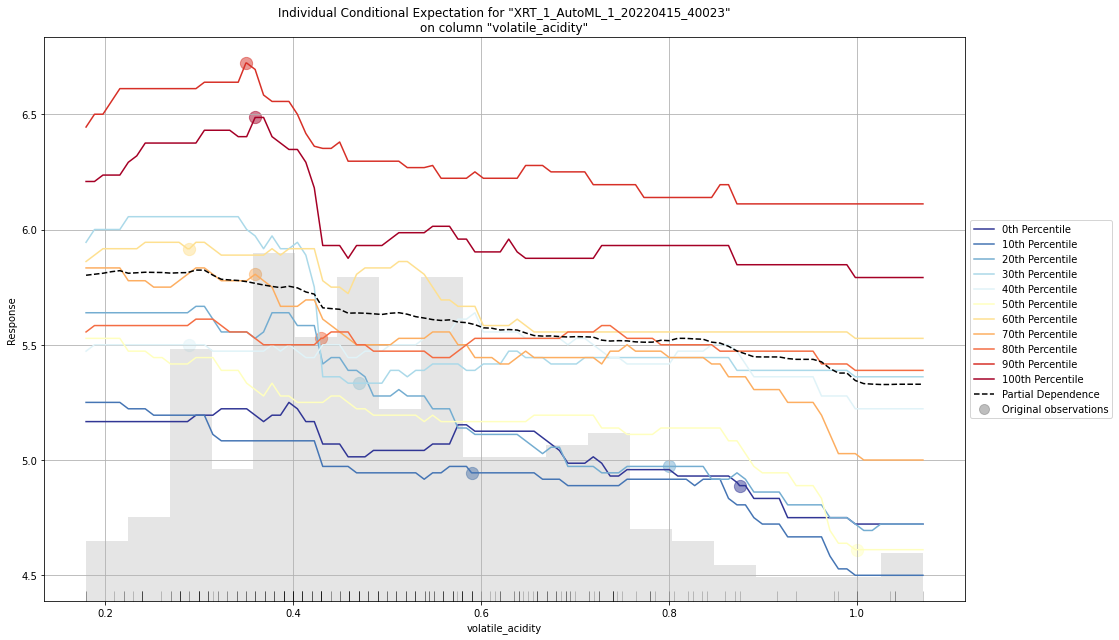

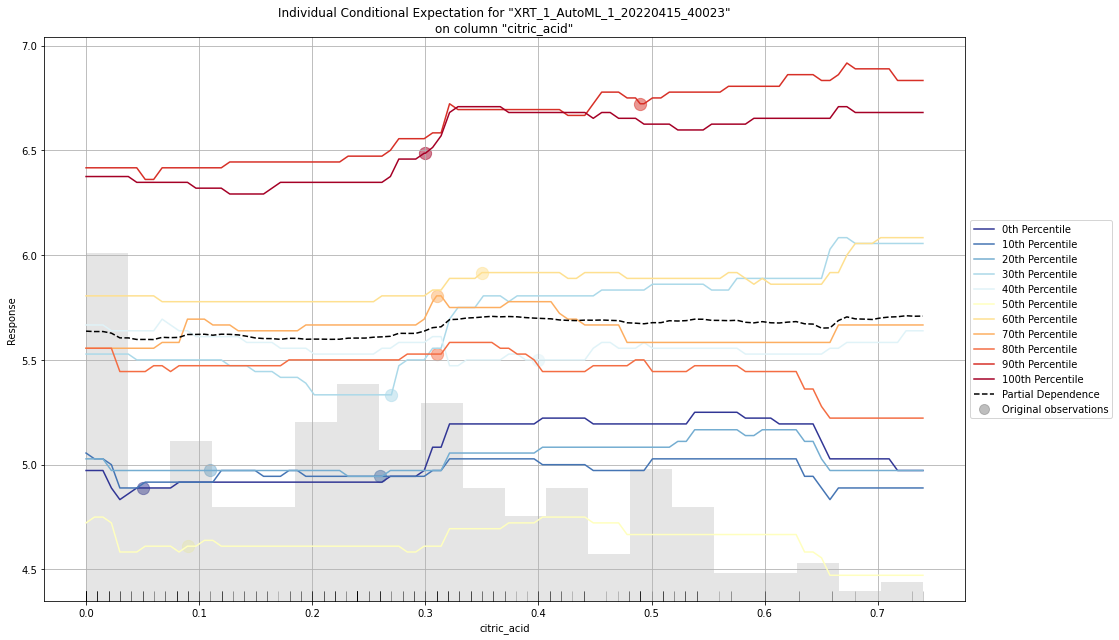

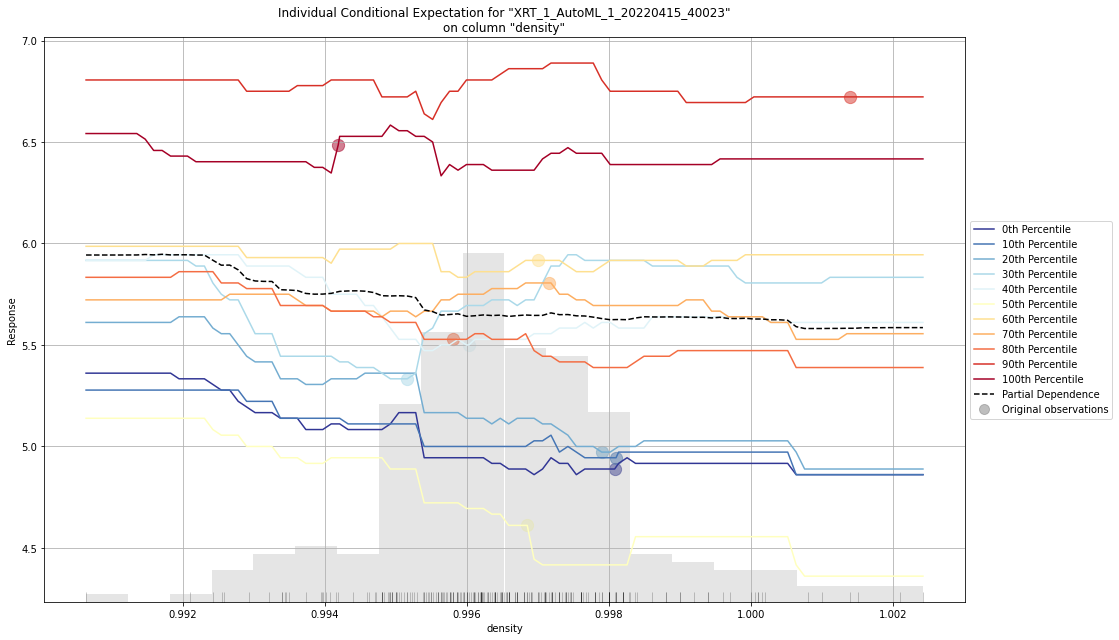

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [22]:
autoML_model.explain(autoML[1])  # AutoML Explainability

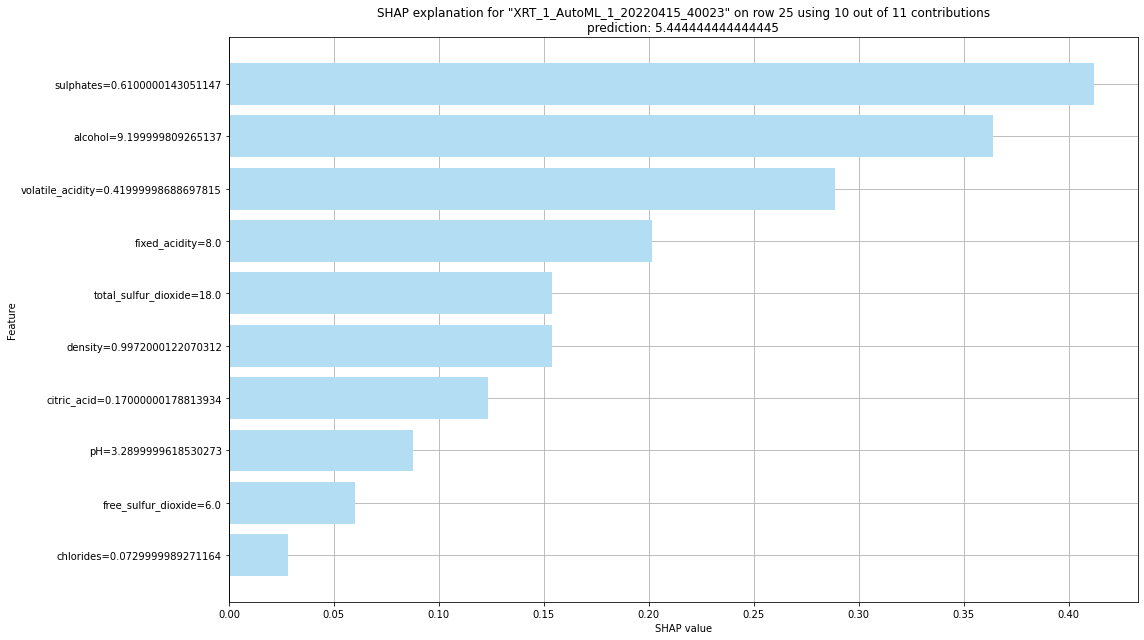

In [23]:
autoML_model.shap_explain_row_plot(
    autoML[1], 25
)  # Lets Analyze the 25th row in Test Data

#Interpreting Best Model from AutoML

##Residual Analysis
- Here, we can see the striped lines of residuals, which is an artifact of having an integer value as a response value, instead of a real value. It can also be observed from the below graph that residuals are normally distributed. Residuals signify that residuals don't have heteroscedasticity.

##Variable Importance
- In the variable importance plot we can observe that the plot replicates the results which we got from the Linear Model and Tree-Based Model above. The variable importance has been scaled between 0 to 1 for ease of understanding

##SHAP Summary
From the SHAP summary diagram, we can interpret a few conclusions - 

1.   All the features are listed as per their importance in making the prediction, that is alcohol is more significant followed by volatile_acidity, and so on. Hence, free_sulphur_dioxide is the least significant predictor in our model.
2.   The position on the SHAP value axis indicates the impact the feature has on the prediction either positive or negative. That is, the more the data point is away from the 0.0 shap value - the more its impact is. As we can see Alcohol has the most impact on the quality of the wine. The color of the dot represents (Red - High, Blue - Low) the impact of the value on the result. i.e. - Hight amount of alcohol results in high quality of wine, a low amount of volatile acidity results in high quality of wine, and so on. As we can see the distribution of red points in the Alcohol feature is far more spread than the blue points. From this visual, we can interpret that the quality of wine vastly increases as the amount of alcohol increases. It doesn't have much impact if the content is low i.e. between the shap value of 0.4 to 0.6 the blue data points are pretty concentrated. Inversely for the Volatile Acidity, less is better for the quality of the wine. Let us analyze the distribution of SHAP values of this feature. As seen in the SHAP plot we can see that extreme values on both ends can have a significant effect on the quality of the wine. 


The advantage of SHAP analysis over normal feature importance is that we could visualize how the feature is affecting the target at different values. The standard methods tend to overestimate the importance of continuous or high-cardinality categorical variables.

##Partial Dependence Plot (PDP)

A partial dependence plot shows the marginal effect of a feature on the target(wine quality in our dataset). It is achieved by keeping all other variables constant and changing the value of one variable to get its PDP.

For Interpretation purposes, let us pick up the two most important variables - Alcohol and Sulphate. 

1.   As we can see that when the rest of the variables are kept constant and a 
marginal change is made in alcohol, we can see the mean response increases between alcohol levels of 11 and 12. This could be interpreted as this range of alcohol could be the deciding factor in the quality of the wine.
2.   Similarly when the rest of the variables are kept constant and a marginal change is made in sulfate we can observe the mean response of quality going up between the sulfate range of 0.4 to 0.8. Hence, it can be interpreted that this range is deciding factor in the quality of the wine. 

The computation of partial dependence plots is intuitive: The partial dependence function at a particular feature value represents the average prediction if we force all data points to assume that feature value.

##ICE (Individual Conditional Expectation) Plot

ICE plot is similar to what we did in the PDP plot, but the fundamental difference between the two methods is that the PDP plot focuses on the average effect of a feature and does not focus on a specific instance. ICE plot comes in rescue to address this drawback of the PDP plot where the outputs from all instances are considered instead of an average value. 

Let us go back to the alcohol and sulfate features, as we interpreted in PDP the quality of wine increases when alcohol and sulfate value is between 11 to 12 and 0.4 to 0.8 respectively. But is this true for every wine in the dataset? ICE plot has an answer to this question. As we can see in the ICE plot above the quality of a few wines(0th percentile instance) increases a lot in this range while the quality of a few doesn't change much(100th Percentile Instance). 

Individual conditional expectation curves are even more intuitive to understand than partial dependence plots. One line represents the predictions for one instance if we vary the feature of interest.

##SHAP explanation for an Individual Wine
Analyzing the 25th wine in the dataset, please refer to the above cell for the Graph Y-axis has the features with its values from the 25th wine and X-axis has its corresponding SHAP values. This graph shows the contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying the inverse link function.




#SHAP Analysis for Linear and Tree-Based Models

Here the x-axis is the feature and the y-axis is the output as we vary the feature. The grey histogram is the distribution of variables in the dataset and the cross made by E[Feature], E[f(x)] is the expected values.

Let us take a feature of fixed_acidity
- For the linear model the cross is made at approx  E[f(x)] 5.74
- For Tree-based model the cross is made at approx E[f(x)] 5.735

So as the fixed_acidity increases the expected value also increases

Talking about the red line on the plot - When we give a sample as an input (sample_ind = 18) as an input to check the output. By plotting this we can see the difference between the model output from the expected value. 

Permutation explainer: 1029it [01:30, 10.46it/s]


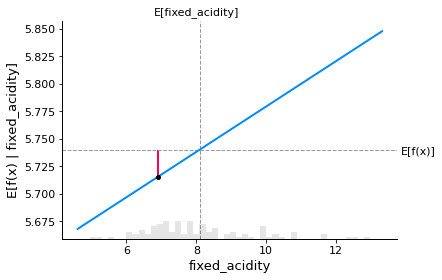

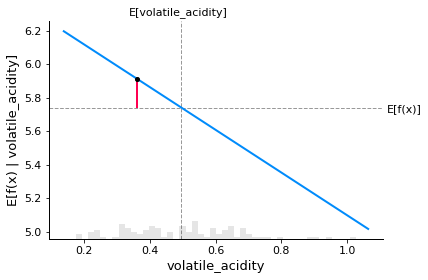

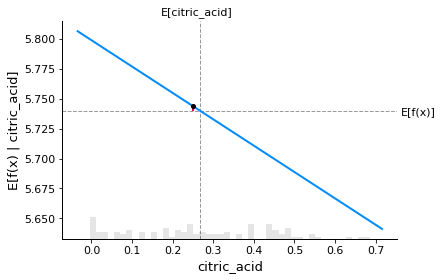

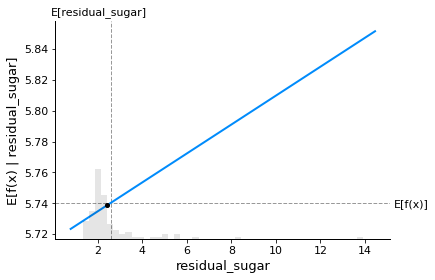

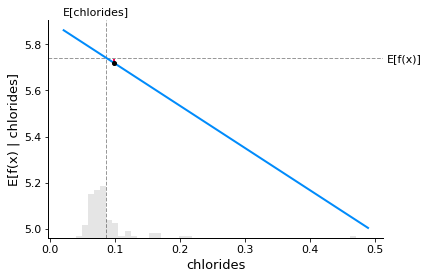

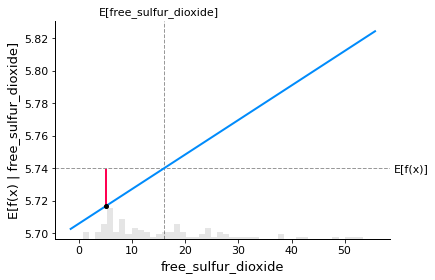

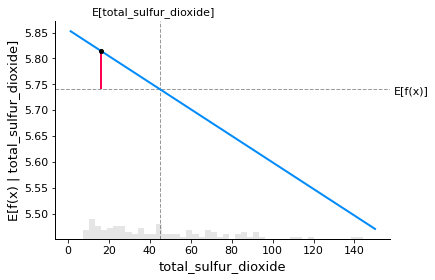

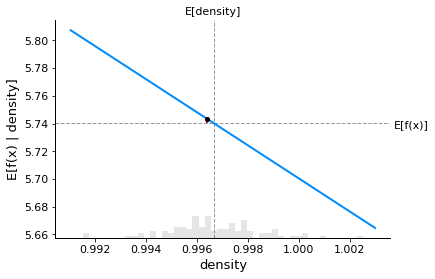

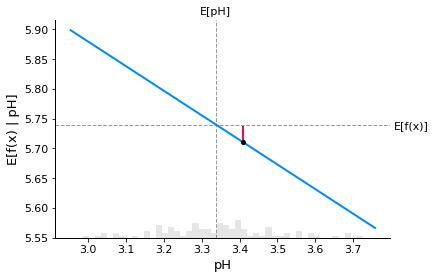

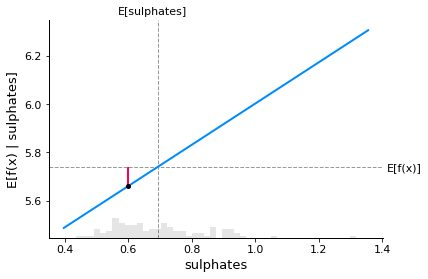

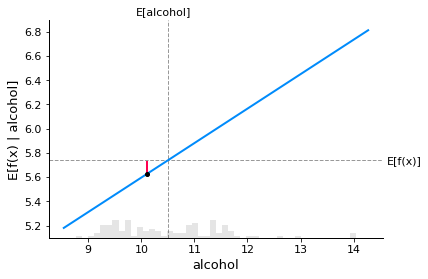

In [24]:
# SHAP explanation of a Linear Model
linear_explainer = shap.Explainer(linear_model.predict, x_train_100)
linear_shap_values = linear_explainer(x_train)
for i in x_train.columns:
    # make a standard partial dependence plot
    sample_ind = 18
    shap.partial_dependence_plot(
        i,
        linear_model.predict,
        x_train_100,
        model_expected_value=True,
        feature_expected_value=True,
        ice=False,
        shap_values=linear_shap_values[sample_ind : sample_ind + 1, :],
    )

SHAP Values - Tree Based Model

Permutation explainer: 1029it [01:43,  8.84it/s]


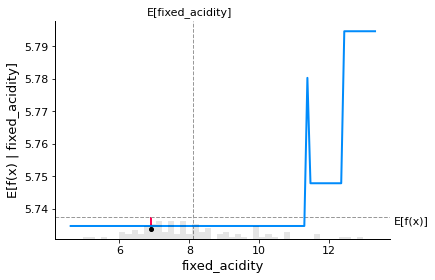

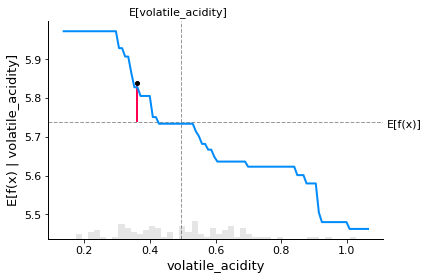

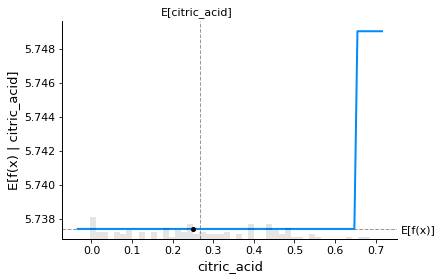

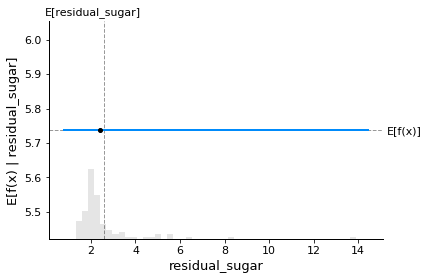

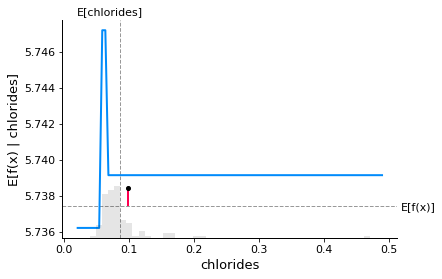

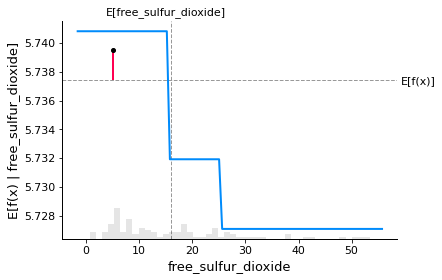

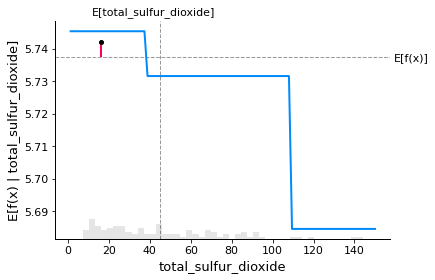

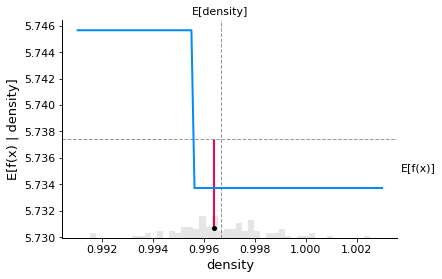

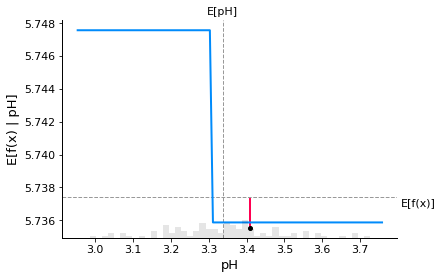

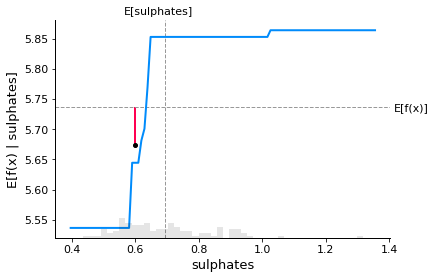

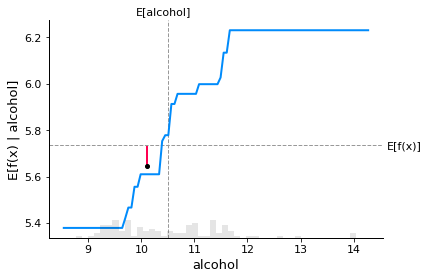

In [25]:
# SHAP explanation of a tree based model
tree_explainer = shap.Explainer(tree_model.predict, x_train_100)
tree_shap_values = tree_explainer(x_train)
for i in x_train.columns:
    # make a standard partial dependence plot
    sample_ind = 18
    shap.partial_dependence_plot(
        i,
        tree_model.predict,
        x_train_100,
        model_expected_value=True,
        feature_expected_value=True,
        ice=False,
        shap_values=tree_shap_values[sample_ind : sample_ind + 1, :],
    )

#Interpreting SHAP Feature Importance Plot for Linear and Tree-based model
The idea behind SHAP feature importance is simple: Features with large absolute Shapley values are important. Since we want global importance, we average the absolute Shapley values per feature across the data. Next, we sort the features by decreasing importance and plot them.

The following plots are 

1.   SHAP feature importance for a linear model
2.   SHAP feature importance for tree-based model

As we can see below in the plots, there is a difference in feature importance for both the models
- For the linear model, volatile_acidity is the second most important feature but for our tree-based model sulfate is the second most important feature when we consider the average of SHAP values to calculate feature importance.




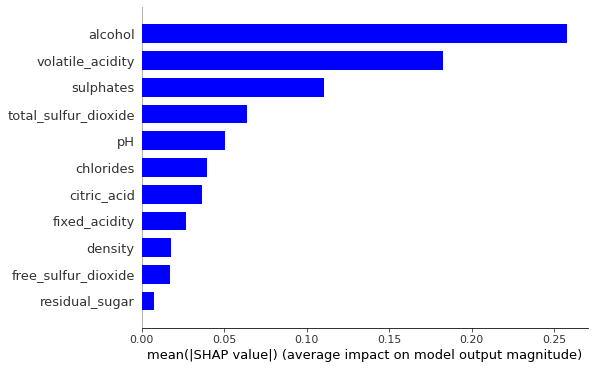

In [26]:
# SHAP variable importance for a Linear Model
shap.summary_plot(linear_shap_values, x_train, plot_type="bar", color="blue")

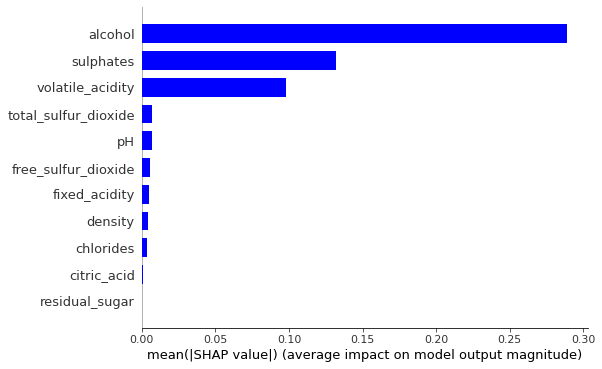

In [27]:
# SHAP variable importance for Tree based model
shap.summary_plot(tree_shap_values, x_train, plot_type="bar", color="blue")

#Interpreting Waterfall SHAP visualization

1. Let's consider the same sample (sample_ind = 18)
Notice the value of volatile_acidity in the waterfall model is the same as what we have in SHAP partial dependence plot. It says that **f(x) = 5.7 is what we got as a model output** and the **expected output for this sample was 5.74**. We came pretty close to determining it as the **difference is only 0.04**. The waterfall model explains how we got the expected output, and which features contributed to what. The below graph shows that volatile_acidity has the biggest and most positive impact in **increasing the quality of wine by 0.17** for this specific sample. Followed by alcohol had a negative impact and it bought the **quality of wine down again by 0.12** for this sample, and so on. Using this model we can visually interpret why exactly this specific sample is giving an output of 5.7.

2. Similarly we can interpret the tree-based model for the same sample.
Where the **output we got was 5.678 and the expected output was 5.74.**
in the tree-based model, we just see that the magnitude of the impact made by individual features varies from what we had in a linear model. Here in the tree-based model, the output is majorly determined by only three features - volatile_acidity, alcohol, and sulfate, whereas in the linear model volatile_acidity, alcohol, and sulfate, total_sulphur_dioxide, pH, fixed_acidity, free_sulphur_dioxide these features had maximum impact.




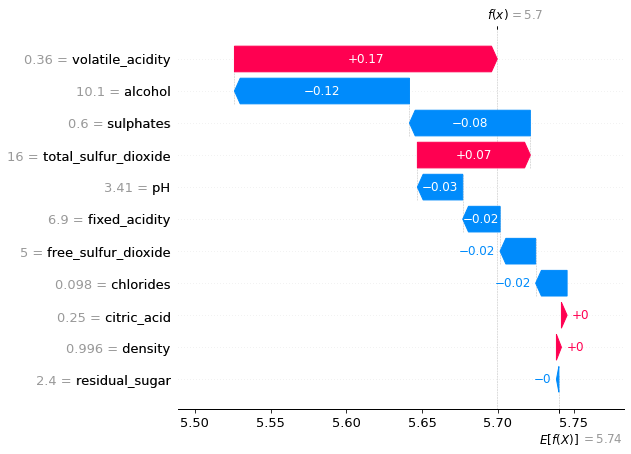

In [28]:
# Waterfall plot for linear model
shap.plots.waterfall(linear_shap_values[sample_ind], max_display=14)

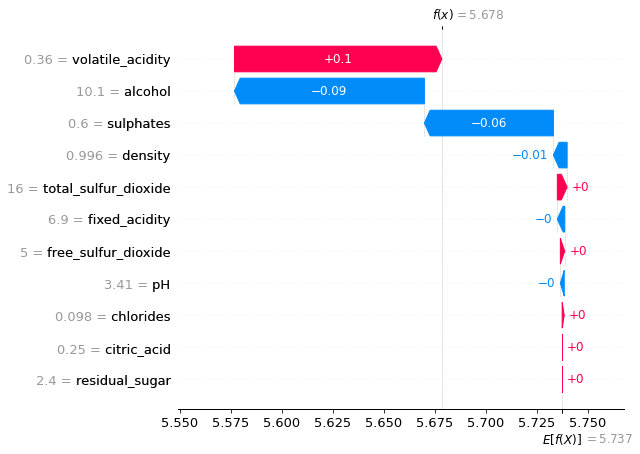

In [29]:
# Waterfall plot for Tree Based Model
shap.plots.waterfall(tree_shap_values[sample_ind], max_display=14)

#Interpret the summary plot for the Linear and Tree-based model
Here the features are listed in descending order of their importance. This is one of the easiest ways to analyze an ML model and how the features are affecting the target and to what extent. 

1. Each dot(both red and blue) represents a feature of a wine
2. Red color represents high values whereas blue color represents low value
3. If a dot(a feature of wine) is on the right side of the y-axis then it had a positive impact and if it is on the left side of the axis it had a negative impact
4. The position of a dot(a feature of wine) on the x-axis represents the intensity of impact it had, the more it is away from the axis greater the intensity.

Let us try to understand how both models are performing side by side

*   Higher value of alcohol tends to have a positive impact on the quality of wine
*   Lower values of volatile_acidity tend to have a positive impact on the quality of the wine.
*  Higher values of sulfates tends to have a positive impact on the quality of wine
* Lower value of total_sulphur_dioxide tends to have a positive impact on the quality of wine, and so on. 

We could also interpret the intensity of impact
- Higher amount of sulfates have a much positive impact on the quality of the wine but it doesn't really care if the value is low it will always have the same intensity of negative impact on the quality

This visualization is very useful when it comes to interpreting how our model is working.  

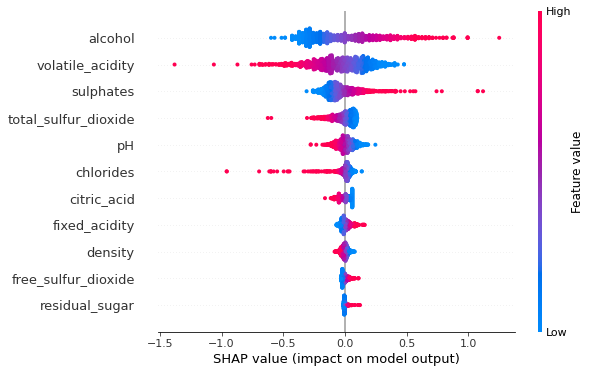

In [30]:
# SHAP summary for Linear Model
shap.summary_plot(linear_shap_values, x_train)

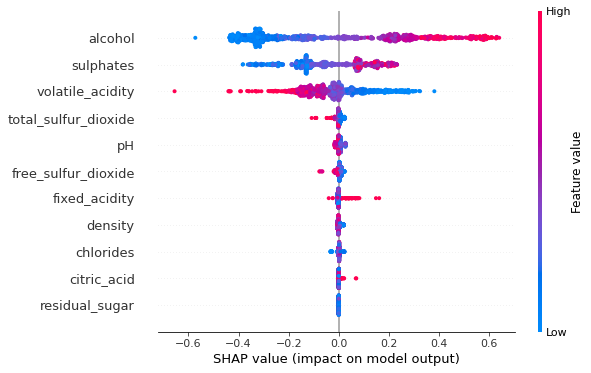

In [31]:
# SHAP summary for Tree Based Model
shap.summary_plot(tree_shap_values, x_train)

#Interpreting SHAP dependence plot for Linear and Tree-based model
The SHAP dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model. It tells whether the relationship between the target and a feature is linear, monotonic, or more complex. Let us interpret the linear and Tree-based models using the SHAP dependence plot. Here in these graphs, we get a dot for every wine in our dataset. 

1. As we can observe the linear model feature and its SHAP value have a linear relationship. If a feature has a positive impact on the wine quality then the relationship will be directly proportional e.g. Alcohol and Sulphate and if the feature harms wine quality the relationship will be inversely proportional. e.g. pH and Density. 

2. For the tree-based model as observed the relationship between feature and its SHAP value is no longer linear. Now we see that the SHAP dependence plot no longer exactly matches the partial dependence plot because they are accounting for the interaction effects. Because if we look at the PDP, we are losing all the high order interaction (and's and or's) in the model that our model may be doing. But unlike PDP, the SHAP defense plot takes these interactions into account. 

**Example of SHAP dependence plot of Alcohol**


1.   In the linear model the relationship is linear between alcohol and its SHAP values. There is not much information to extract from these plots the only information which could be extracted is if the relationship is directly or inversely proportional. 
2.   In the tree-based model we could extract the information on how the quality of each wine is affected while being tuned the feature. It also reinforces the inference we got from the above PDP and ICE plot i.e. The quality of wine in the range (10 - 12) changes drastically. 








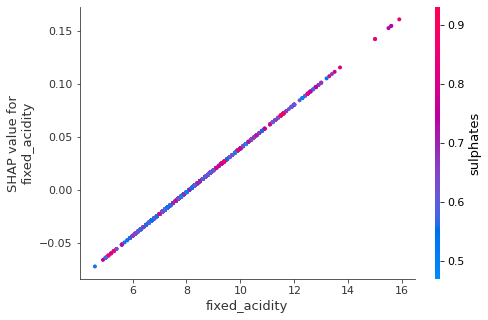

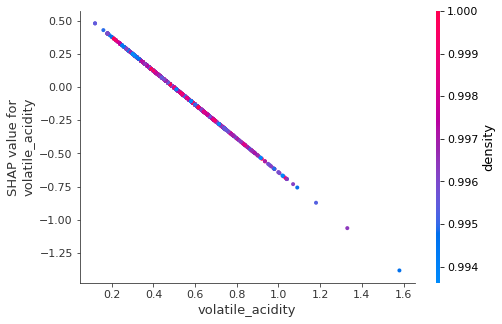

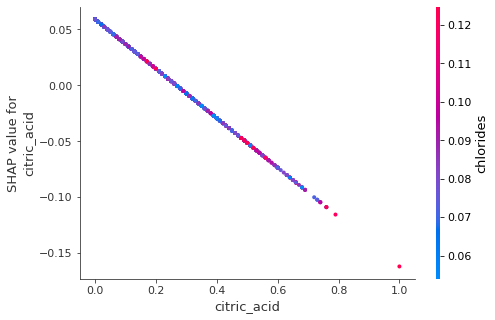

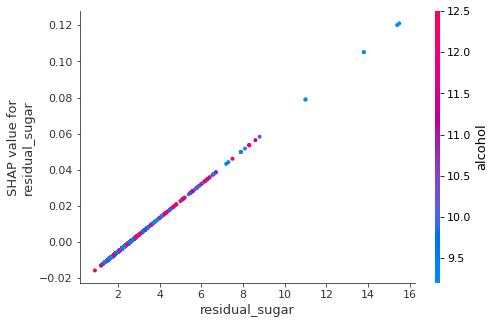

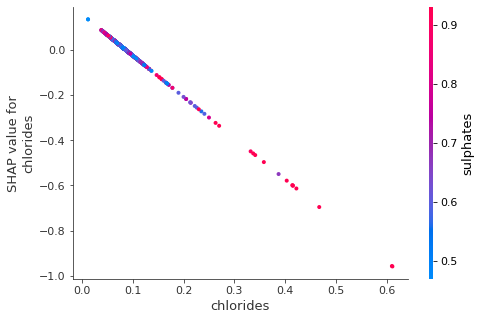

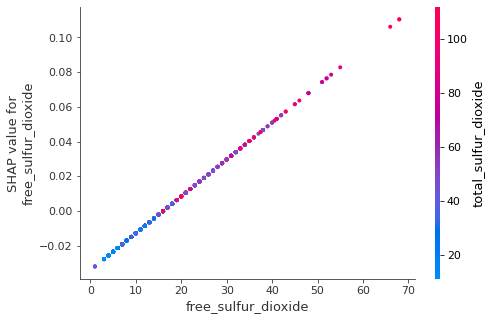

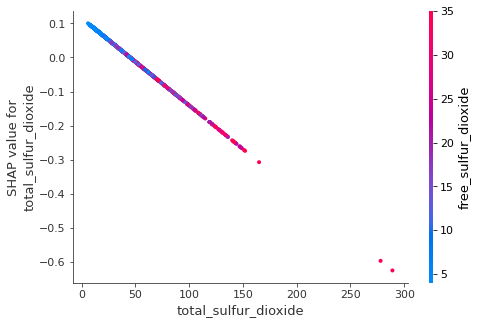

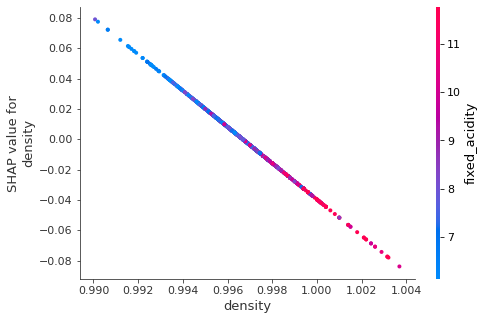

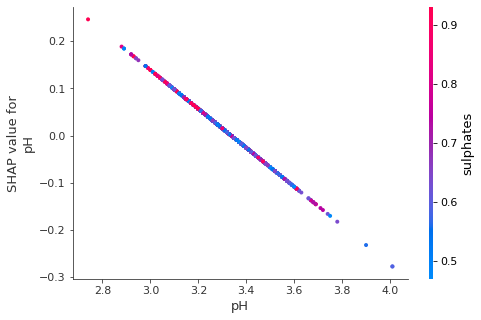

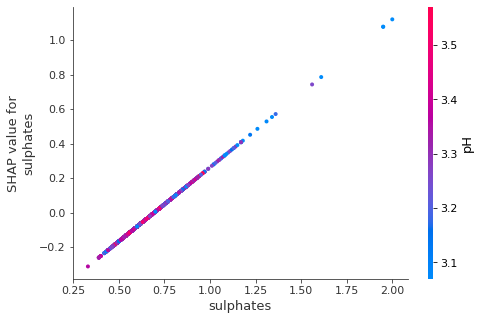

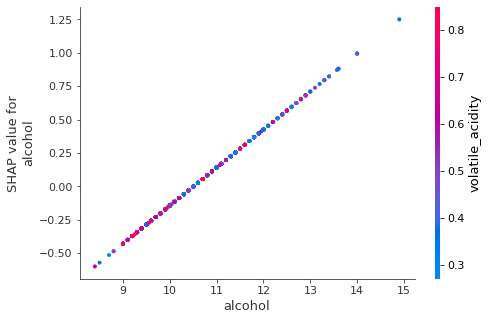

In [32]:
# SHAP partial dependence plot for linear model
for i in x_train.columns:
    shap.dependence_plot(i, linear_shap_values.values, x_train)

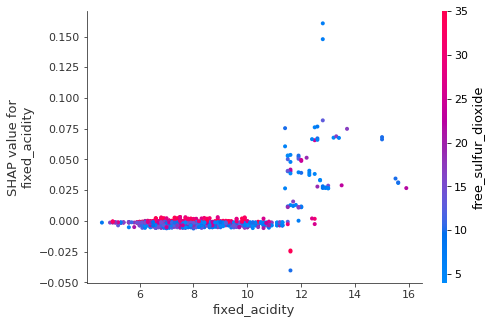

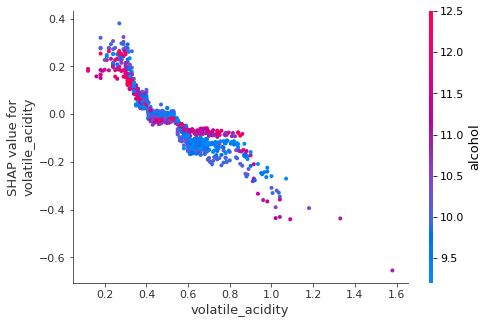

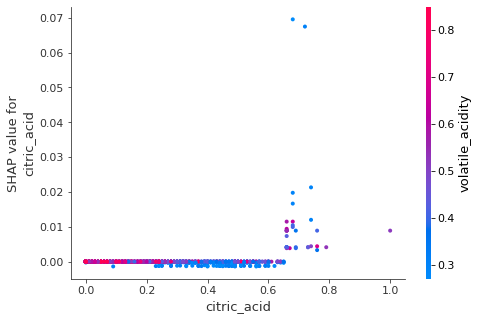

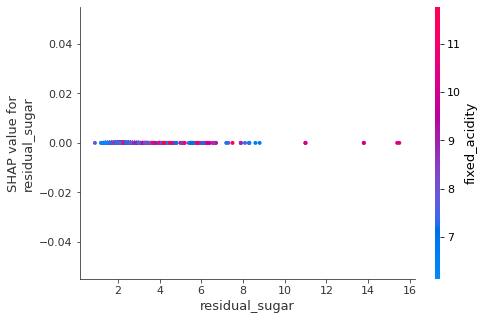

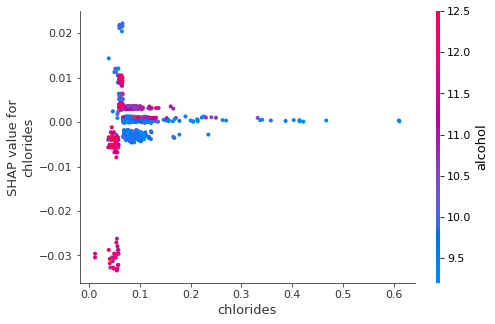

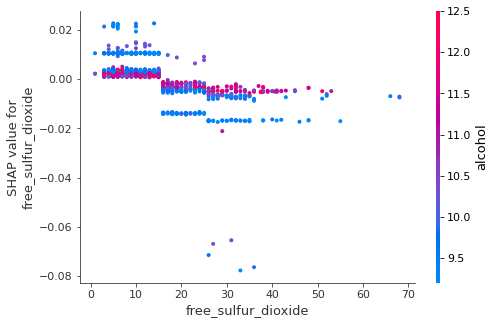

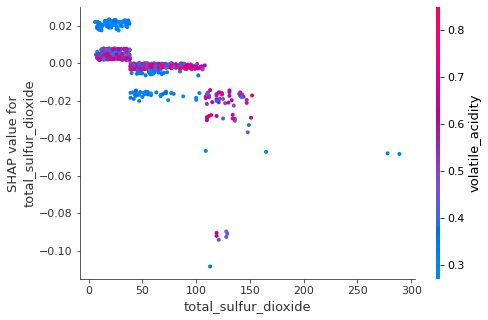

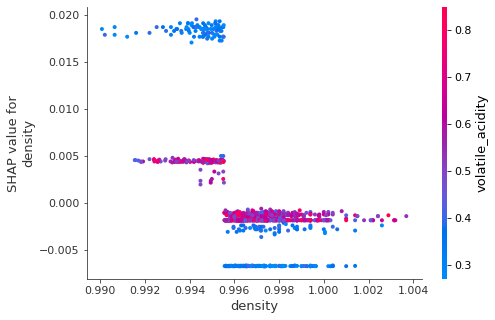

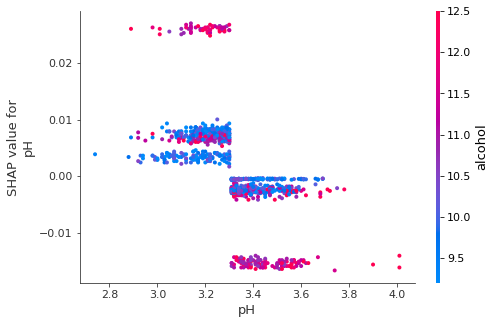

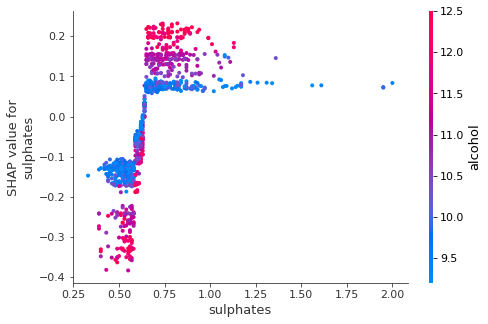

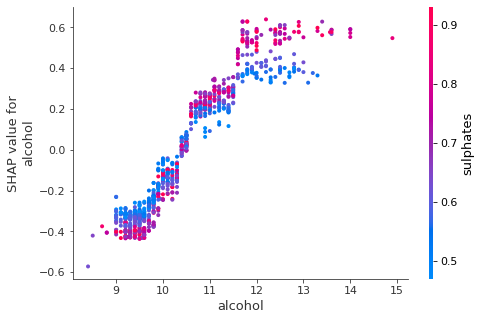

In [33]:
# SHAP partial dependence plot for a tree based model
for i in x_train.columns:
    shap.dependence_plot(i, tree_shap_values.values, x_train)

In [34]:
X_output_linear = x_test.copy()
X_output_linear.loc[:, "predict"] = np.round(
    linear_model.predict(X_output_linear), 2
)  # Attaching the output of linear model to test dataframe

X_output_tree = x_test.copy()
X_output_tree.loc[:, "predict"] = np.round(
    tree_model.predict(X_output_tree), 2
)  # Attaching the output of tree based model to test dataframe

In [35]:
# Force Plot of Tree Based Model
explainerModel = shap.TreeExplainer(tree_model)
shap_values_Model = explainerModel.shap_values(X_output_tree)


def shap_plot_tree(j):
    p = shap.force_plot(
        explainerModel.expected_value, shap_values_Model[j], X_output_tree.iloc[[j]]
    )
    return p

#Force Plot SHAP analysis
This plot is the same as the waterfall model which we saw above the only difference is the visualization is condensed. It is really up to an individual which visualization is preferred some find this easier to read others find the waterfall model easier to read

Let us consider one sample from the test set, Please refer to the Force Plot below 
- The output of the model is 5.42 
- The features which had a significant positive impact on wine quality were alcohol and sulfates with 9.8 and 0.46 respectively
- The features which had a significant negative impact on wine quality were volatile_acidity, free_sulphur_dioxide with 0.53 and 3 respectively

It gives us the same information which the waterfall model has to give

In [36]:
shap.initjs()  # Initializing JavaScript module
shap_plot_tree(18)  # SHAP force plot for sample 18

#Heatmap Visualization for Linear and Tree-based model

This visualization is a summarization of the entire dataset on how each data point in every feature is affecting the target(quality of wine). 
- Here the Y-axis is Features
- and X-axis is Instance of that feature
- The color of the instance defines if it had a positive effect or negative effect by its color. If the instance is red then it had a positive effect and if the instance is blue then it had a negative effect
- The intensity of the color is directly proportional to the intensity of the effect. Deeper the color, the more impactful the feature is

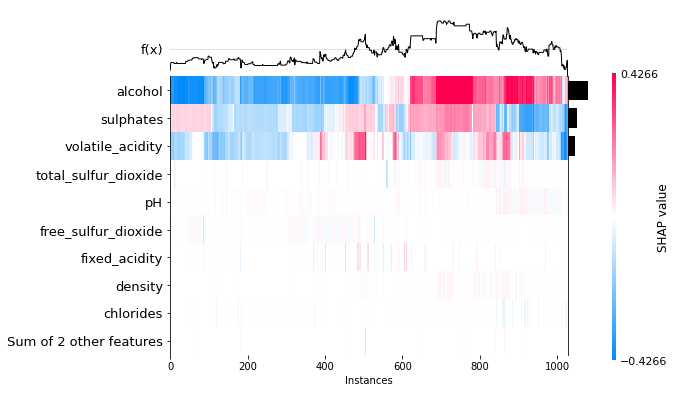

In [37]:
shap.plots.heatmap(tree_shap_values)  # SHAP HeatMap of a Tree Based Model

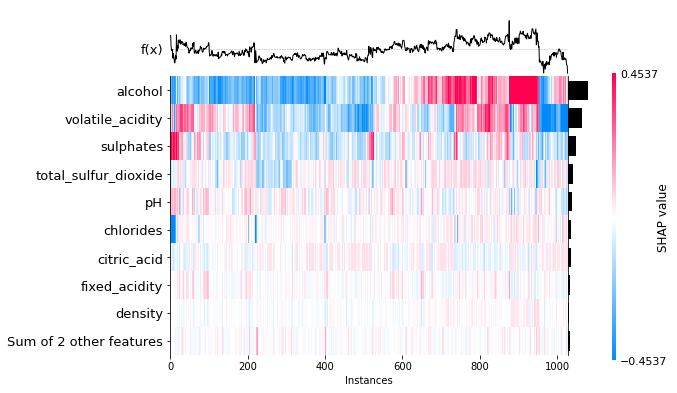

In [38]:
shap.plots.heatmap(linear_shap_values)  # SHAP heatmap for a Linear Model

## LIME (Local Interpretation Model-Agnostic Explanation) Analysis

- LIME builds a surrogate model, i.e. converts a more complicated model (say a deep tree-based model into a simple linear model) around the data points in which we are interested and then it will try to make an approximation out of this simple model on the whole model. LIME builds a local model in such a way that it can interpret the whole Black-Box

- LIME works well on tabular, text, image datasets - hence it works on different datasets

Let us Interpret our Linear model and Tree-based model on sample data (sample_index = 18) using LIME and try to understand what is happening under the hood. Please refer below for Visualizations of both models
- As we can see on the left-hand side LIME gives us information about the minimum and maximum values predicted by the model. The Color orange here represents positive and blue represents negative
- Here for this sample as seen below alcohol, sulfate, volatile_acidity, residual_sugar harmed both linear and tree-based model
- total_sulphur_dioxide, density, pH, citric_acid, had a positive effect on the quality of wine in both models
- fixed_acidity, free_sulphur_dioxide, chloride had a negative effect in the linear model but positive in tree-based model

These interpretations were carried out locally in the region where of out sample data(sample_index = 18).

## Linear Model

In [39]:
# Initializing LIME explainer for Linear Model
lime_linear_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(x_train), feature_names=x_train.columns, mode="regression"
)

In [40]:
# Getting LIME interpretation for a sample data
idx = 18
np_x_test = np.array(x_test)
np_y_test = np.array(y_test)
print("Prediction : ", linear_model.predict(np_x_test[0].reshape(1, -1)))
print("Actual :     ", np_y_test[idx])

lime_linear_explanation = lime_linear_explainer.explain_instance(
    np_x_test[idx], linear_model.predict, num_features=np_x_test.shape[1]
)
lime_linear_explanation

X does not have valid feature names, but LinearRegression was fitted with feature names


Prediction :  [5.34607837]
Actual :      5


X does not have valid feature names, but LinearRegression was fitted with feature names


In [41]:
lime_linear_explanation.show_in_notebook()  # Display Results in Notebook

## Tree Based Model

In [42]:
# Initializing LIME explainer for Tree Based Model
lime_tree_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(x_train), feature_names=x_train.columns, mode="regression"
)

In [43]:
# Getting LIME interpretation for a sample data
idx = 18
np_x_test = np.array(x_test)
np_y_test = np.array(y_test)
print("Prediction : ", tree_model.predict(np_x_test[0].reshape(1, -1)))
print("Actual :     ", np_y_test[idx])

lime_tree_explanation = lime_linear_explainer.explain_instance(
    np_x_test[idx], tree_model.predict, num_features=np_x_test.shape[1]
)
lime_tree_explanation

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Prediction :  [5.17549154]
Actual :      5


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


In [44]:
lime_tree_explanation.show_in_notebook()  # Display Results in Notebook

#PDP(Partial Dependence Plot) for Linear model and Tree-based Model
1.   **Linear Model** - 
If we closely look at the PDP of the linear model we can see that if features volatile_acidity, sulfates, alcohol are tuned while freezing the rest if them the output of the model varies linearly and these variables have the most significant effect on the output(quality of wine)
2.   **Tree-Based Model** -
On looking at the PDP of the tree-based model, it re-affirms the interpretation we got from the PDP of the Linear Model and Best AutoML model. The only difference here is that the output doesn't vary linearly



Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


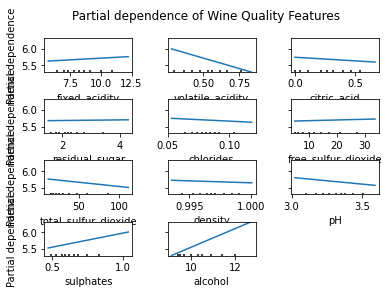

In [45]:
# PDP Plot for Linear Model
plot_partial_dependence(
    linear_model, x_test, x_test.columns, n_jobs=3, grid_resolution=20
)

fig = plt.gcf()
fig.suptitle("Partial dependence of Wine Quality Features")
fig.subplots_adjust(wspace=0.4, hspace=0.8)
plt.show()
plt.rcParams["figure.figsize"] = (32, 24)

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


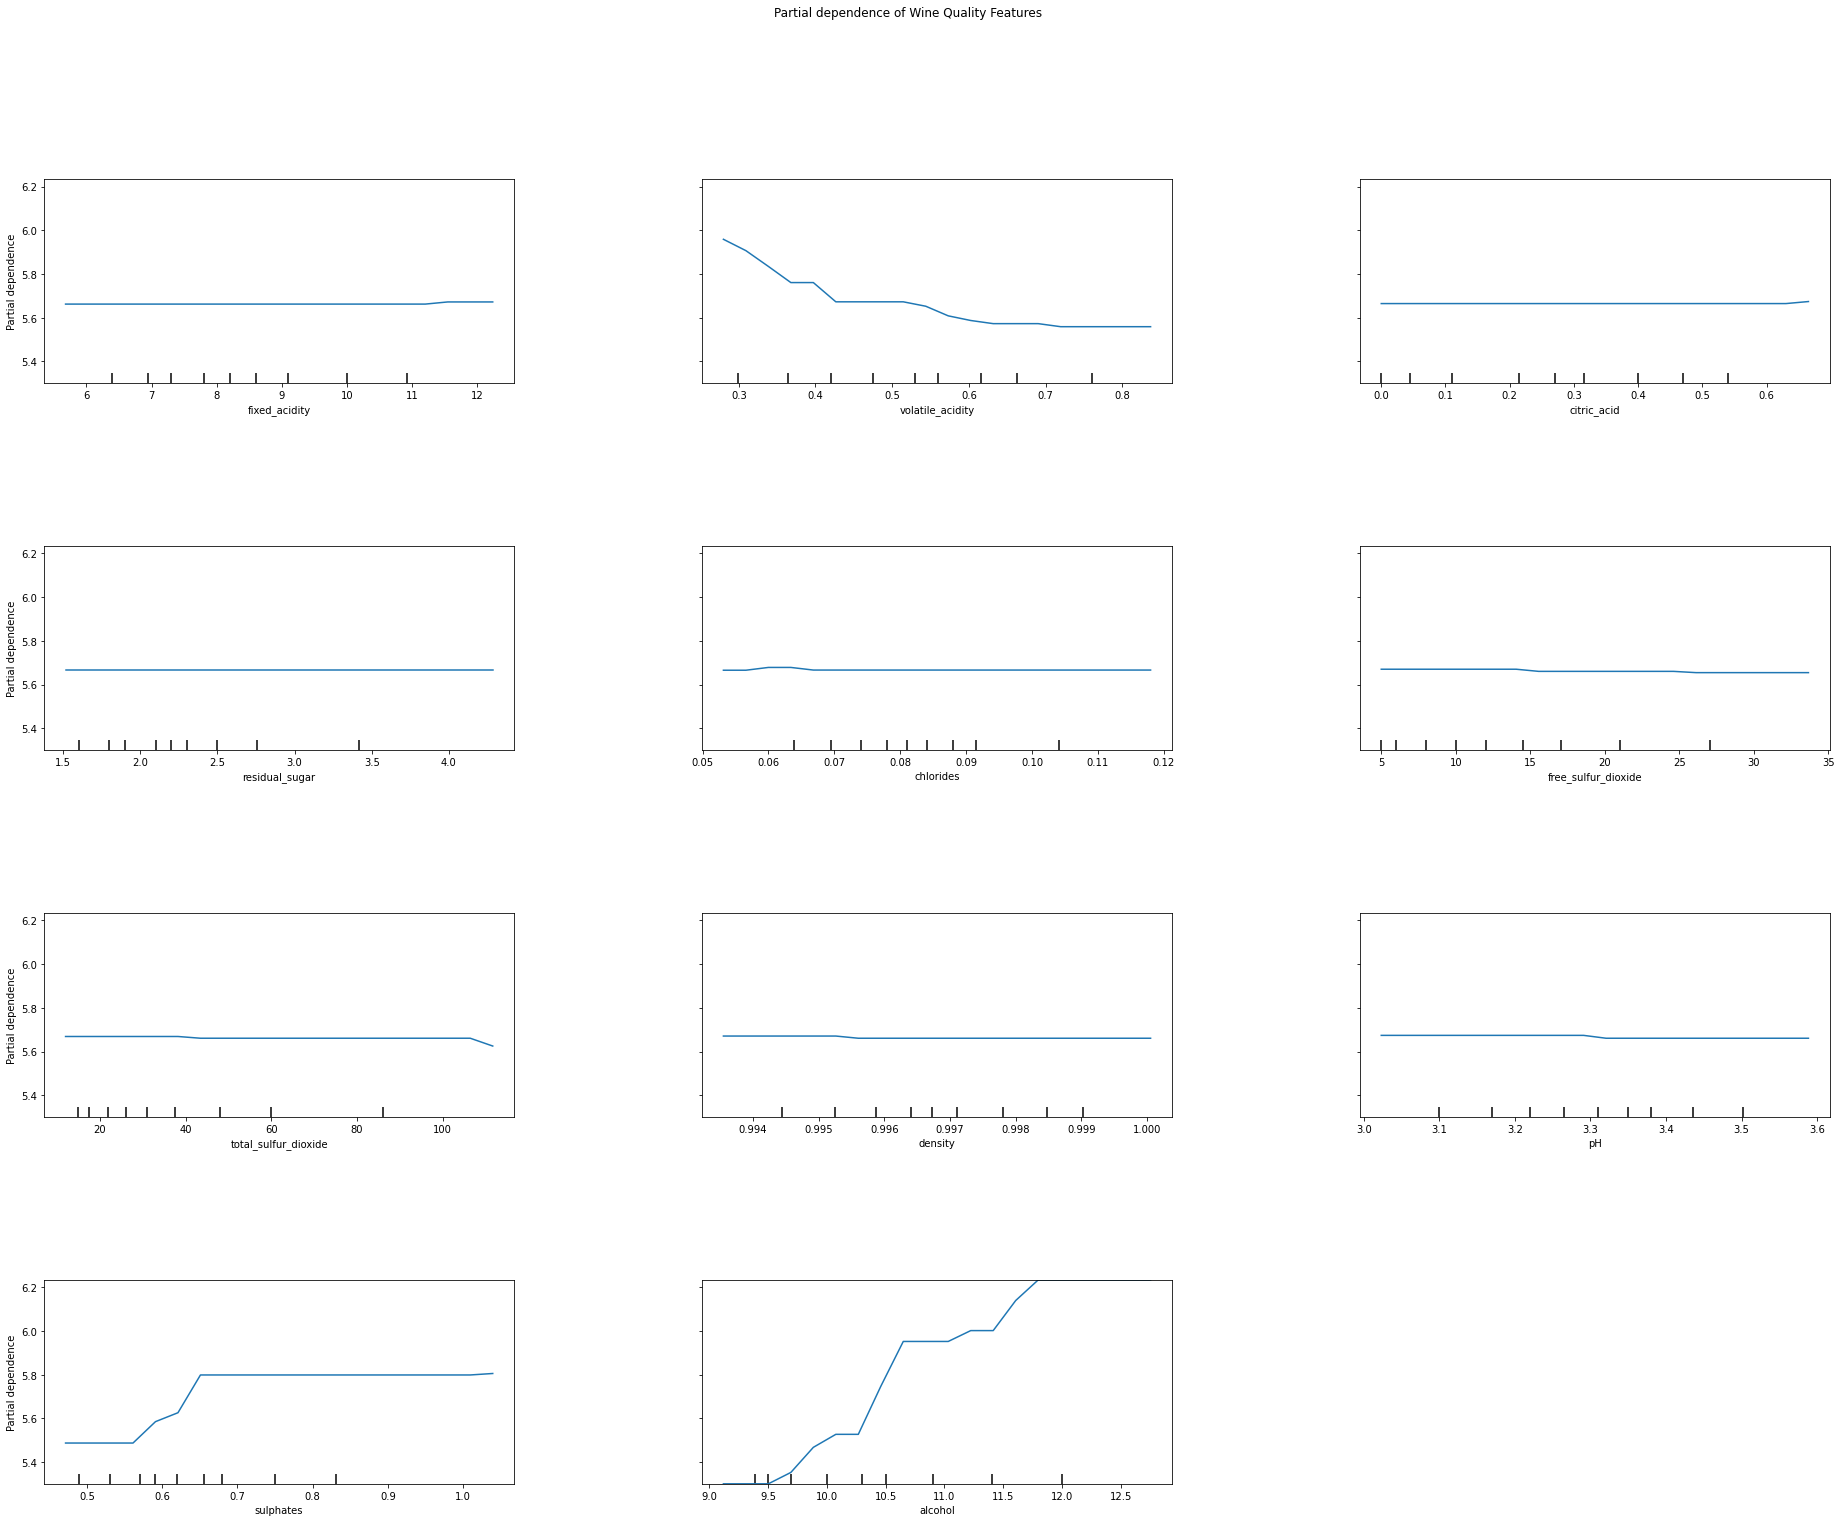

In [47]:
# PDP Plot for Tree based Model
plot_partial_dependence(
    tree_model, x_test, x_test.columns, n_jobs=3, grid_resolution=20
)


fig = plt.gcf()
fig.suptitle("Partial dependence of Wine Quality Features")
fig.subplots_adjust(wspace=0.4, hspace=0.8)
plt.show()
plt.rcParams["figure.figsize"] = (32, 24)

#Comparision between SHAP, LIME, and Partial Dependence Plot Analysis
Unlike LIME, SHAP does not necessarily build a local interpretable model but rather uses the black-box model to calculate the marginal contribution to the prediction for each feature and then relies on the theoretically sound game theory concept of Shapley values to calculate the feature importance. In this way, SHAP improves upon LIME due to its greater stability and lack of local linear model assumptions.

- PDP gives the extent of effect a variable has on the output by freezing the rest of them
- SHAP gives how much each variable contributes to the prediction
- LIME is more like SHAP but a lite version of it - It takes the local region of the point of interest and gives us information about the contribution each variable has made to the output

We have to analyze our needs and then consider the tradeoff to select the best suitable interpretable method for the ML model

#References

* Molnar, C. (2022). Interpretable Machine Learning: A Guide for Making Black Box Models Explainable (2nd ed.) 
christophm.github.io/interpretable-ml-book/
* https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
* https://medium.com/@kalia_65609/interpreting-an-nlp-model-with-lime-and-shap-834ccfa124e4#:~:text=Unlike%20LIME%2C%20SHAP%20does%20not,to%20calculate%20the%20feature%20importance.